In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


# 🌦️ Indian Cities Weather Analysis & SARIMA Forecasting

**Analysis Period:** 2000-2024 (25 years)  
**Cities Analyzed:** 10 major Indian cities  
**Methods:** Time series analysis, SARIMA forecasting  

---

In [2]:
# Configuration Constants
CSV_FILE = "india_2000_2024_daily_weather.csv"
TRAIN_START = '2000-01-01'
TRAIN_END = '2023-12-31'
TEST_START = '2024-01-01'
FORECAST_PERIODS = 12
CONFIDENCE_LEVEL = 0.95

# Cities to analyze (will be extracted from data)
CITIES = None  # Will be populated after loading data

print("✓ Configuration loaded")
print(f"  • Training period: {TRAIN_START} to {TRAIN_END}")
print(f"  • Test period: {TEST_START} onwards")
print(f"  • Forecast horizon: {FORECAST_PERIODS} months")

✓ Configuration loaded
  • Training period: 2000-01-01 to 2023-12-31
  • Test period: 2024-01-01 onwards
  • Forecast horizon: 12 months


## 📂 Data Loading & Initial Exploration

In [3]:
# Load data with proper date parsing
try:
    df = pd.read_csv(CSV_FILE, parse_dates=['date'])
    print(f"✓ Successfully loaded data from: {CSV_FILE}")
except FileNotFoundError:
    print(f"✗ Error: Could not find '{CSV_FILE}'")
    print("Please ensure the CSV file is in the same directory as this notebook,")
    print("or update the 'CSV_FILE' variable with the correct path.")
    raise

✓ Successfully loaded data from: india_2000_2024_daily_weather.csv


In [4]:
# Display basic information
print(df.head())
print(f"\nTotal rows and columns: {df.shape}")
print(f"Total rows: {df.shape[0]:,}")
print(f"Total columns: {df.shape[1]}")

    city       date  temperature_2m_max  temperature_2m_min  \
0  Delhi 2000-01-01                19.9                 7.4   
1  Delhi 2000-01-02                20.0                 5.5   
2  Delhi 2000-01-03                20.1                 6.3   
3  Delhi 2000-01-04                19.8                 6.4   
4  Delhi 2000-01-05                19.4                 5.3   

   apparent_temperature_max  apparent_temperature_min  precipitation_sum  \
0                      19.2                       5.8                0.0   
1                      18.9                       3.4                0.0   
2                      18.2                       4.3                0.0   
3                      18.5                       4.2                0.0   
4                      17.7                       3.2                0.0   

   rain_sum  weather_code  wind_speed_10m_max  wind_gusts_10m_max  \
0       0.0             0                10.9                13.3   
1       0.0             3 

## ✅ Data Quality Validation

In [5]:
# Check for missing values
null_counts = df.isnull().sum()
print("Missing values per column:")
print(null_counts)

if null_counts.sum() == 0:
    print("\n✓ No missing values found!")
else:
    print(f"\n⚠️ WARNING: Found {null_counts.sum()} missing values")

Missing values per column:
city                           0
date                           0
temperature_2m_max             0
temperature_2m_min             0
apparent_temperature_max       0
apparent_temperature_min       0
precipitation_sum              0
rain_sum                       0
weather_code                   0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
dtype: int64

✓ No missing values found!


In [6]:
# Display data types and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91320 entries, 0 to 91319
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   city                         91320 non-null  object        
 1   date                         91320 non-null  datetime64[ns]
 2   temperature_2m_max           91320 non-null  float64       
 3   temperature_2m_min           91320 non-null  float64       
 4   apparent_temperature_max     91320 non-null  float64       
 5   apparent_temperature_min     91320 non-null  float64       
 6   precipitation_sum            91320 non-null  float64       
 7   rain_sum                     91320 non-null  float64       
 8   weather_code                 91320 non-null  int64         
 9   wind_speed_10m_max           91320 non-null  float64       
 10  wind_gusts_10m_max           91320 non-null  float64       
 11  wind_direction_10m_dominant  91320 non-nu

In [7]:
# Data Validation Checks
print("="*80)
print("DATA VALIDATION REPORT")
print("="*80)

# 1. Check for duplicate date entries per city
duplicates = df.groupby(['city', 'date']).size()
duplicate_count = (duplicates > 1).sum()
if duplicate_count > 0:
    print(f"\n⚠️ WARNING: Found {duplicate_count} duplicate date entries!")
    print("Sample duplicates:")
    print(df[df.duplicated(['city', 'date'], keep=False)].head())
else:
    print("\n✓ No duplicate date entries found")

# 2. Check if dates are in chronological order
for city in df['city'].unique():
    city_data = df[df['city'] == city].copy()
    if not city_data['date'].is_monotonic_increasing:
        print(f"\n⚠️ WARNING: Dates for {city} are not in chronological order!")
        break
else:
    print("✓ All dates are in chronological order")

# 3. Check for reasonable temperature ranges (-50°C to 60°C)
temp_outliers = df[
    (df['temperature_2m_max'] < -50) | 
    (df['temperature_2m_max'] > 60) |
    (df['temperature_2m_min'] < -50) | 
    (df['temperature_2m_min'] > 60)
]
if len(temp_outliers) > 0:
    print(f"\n⚠️ WARNING: Found {len(temp_outliers)} temperature outliers!")
    print("Sample outliers:")
    print(temp_outliers[['city', 'date', 'temperature_2m_max', 'temperature_2m_min']].head())
else:
    print("✓ All temperatures are within reasonable ranges")

# 4. Check for negative precipitation (impossible)
neg_precip = df[df['precipitation_sum'] < 0]
if len(neg_precip) > 0:
    print(f"\n⚠️ WARNING: Found {len(neg_precip)} negative precipitation values!")
else:
    print("✓ No negative precipitation values found")

# 5. Display date range
print(f"\n✓ Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"✓ Total days: {(df['date'].max() - df['date'].min()).days + 1}")

# 6. Cities in dataset
CITIES = sorted(df['city'].unique())
print(f"\n✓ Cities in dataset ({len(CITIES)}): {', '.join(CITIES)}")

print("\n" + "="*80)
print("VALIDATION COMPLETE")
print("="*80)

DATA VALIDATION REPORT

✓ No duplicate date entries found
✓ All dates are in chronological order
✓ All temperatures are within reasonable ranges
✓ No negative precipitation values found

✓ Date range: 2000-01-01 to 2024-12-31
✓ Total days: 9132

✓ Cities in dataset (10): Ahmedabad, Bangalore, Chennai, Delhi, Hyderabad, Jaipur, Kolkata, Lucknow, Mumbai, Pune

VALIDATION COMPLETE


## 📊 Visualization 1: Monthly Climate Overview (All Cities Combined)

This shows the typical seasonal pattern averaged across all 10 cities over 25 years (2000-2024):
- **Red line** = Mean monthly temperature (averaged across all cities)
- **Shaded pink area** = ±1 Standard Deviation (year-to-year variability)
- **Blue bars** = Mean daily precipitation by month

**Note:** The shaded area shows how much each month's temperature varies from year to year, indicating climate reliability.



Key Observations:
  - Hottest month: 5 (36.8°C)
  - Coolest month: 1 (25.7°C)
  - Wettest month: 7 (9.7mm)
  - Year-to-year temperature variability: ±0.8°C (avg across months)


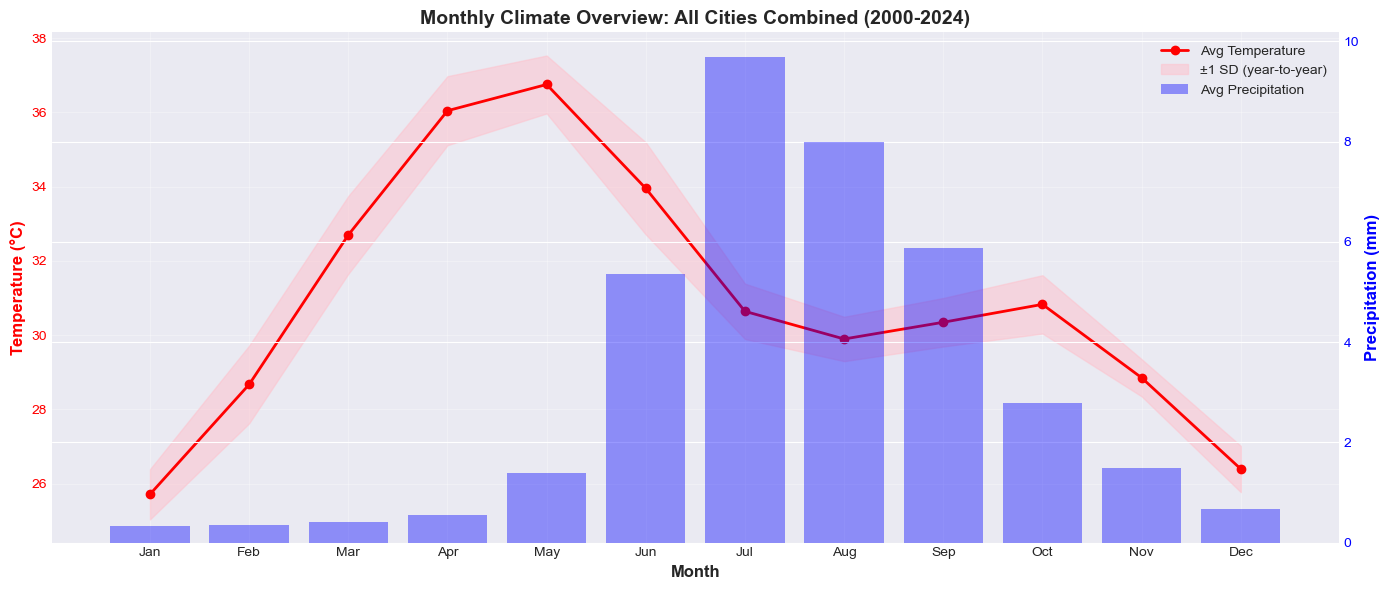

In [10]:
# Add month column for grouping
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Step 1: Calculate monthly average for each city-year combination
monthly_by_city_year = df.groupby(['year', 'month']).agg({
    'temperature_2m_max': 'mean',
    'precipitation_sum': 'mean'
}).reset_index()

# Step 2: Calculate mean and SD of monthly averages (year-to-year variability)
monthly_stats = monthly_by_city_year.groupby('month').agg({
    'temperature_2m_max': ['mean', 'std'],
    'precipitation_sum': 'mean'
}).reset_index()

# Flatten column names
monthly_stats.columns = ['month', 'temp_mean', 'temp_std', 'precip_mean']

# Create visualization
fig, ax1 = plt.subplots(figsize=(14, 6))

# Temperature plot
ax1.plot(monthly_stats['month'], monthly_stats['temp_mean'],
         color='red', linewidth=2, marker='o', label='Avg Temperature')
ax1.fill_between(monthly_stats['month'],
                  monthly_stats['temp_mean'] - monthly_stats['temp_std'],
                  monthly_stats['temp_mean'] + monthly_stats['temp_std'],
                  color='pink', alpha=0.5, label='±1 SD (year-to-year)')
ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
ax1.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.grid(True, alpha=0.3)

# Precipitation plot
ax2 = ax1.twinx()
ax2.bar(monthly_stats['month'], monthly_stats['precip_mean'],
        color='blue', alpha=0.4, label='Avg Precipitation')
ax2.set_ylabel('Precipitation (mm)', fontsize=12, fontweight='bold', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and legends
ax1.set_title('Monthly Climate Overview: All Cities Combined (2000-2024)',
              fontsize=14, fontweight='bold')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()

print("\nKey Observations:")
print(f"  - Hottest month: {monthly_stats.loc[monthly_stats['temp_mean'].idxmax(), 'month']} ({monthly_stats['temp_mean'].max():.1f}°C)")
print(f"  - Coolest month: {monthly_stats.loc[monthly_stats['temp_mean'].idxmin(), 'month']} ({monthly_stats['temp_mean'].min():.1f}°C)")
print(f"  - Wettest month: {monthly_stats.loc[monthly_stats['precip_mean'].idxmax(), 'month']} ({monthly_stats['precip_mean'].max():.1f}mm)")
print(f"  - Year-to-year temperature variability: ±{monthly_stats['temp_std'].mean():.1f}°C (avg across months)")


## 📊 Visualization 2: Historical Time Series by City

Shows the monthly temperature and precipitation trends for each city over the entire 25-year period.

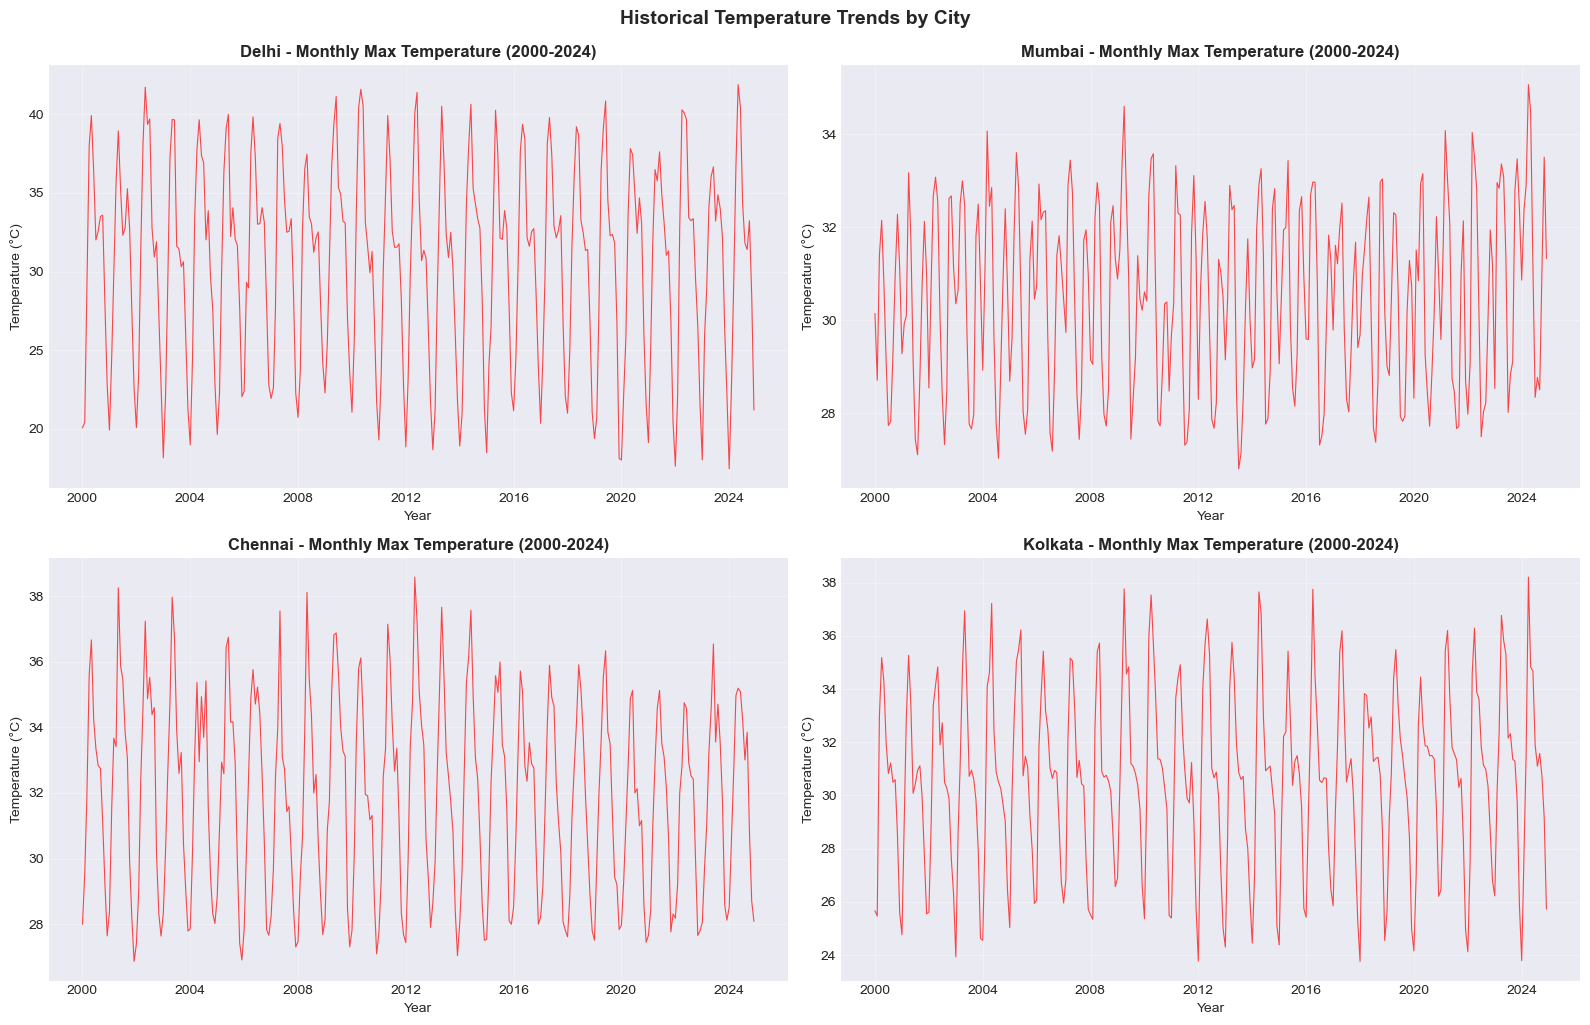

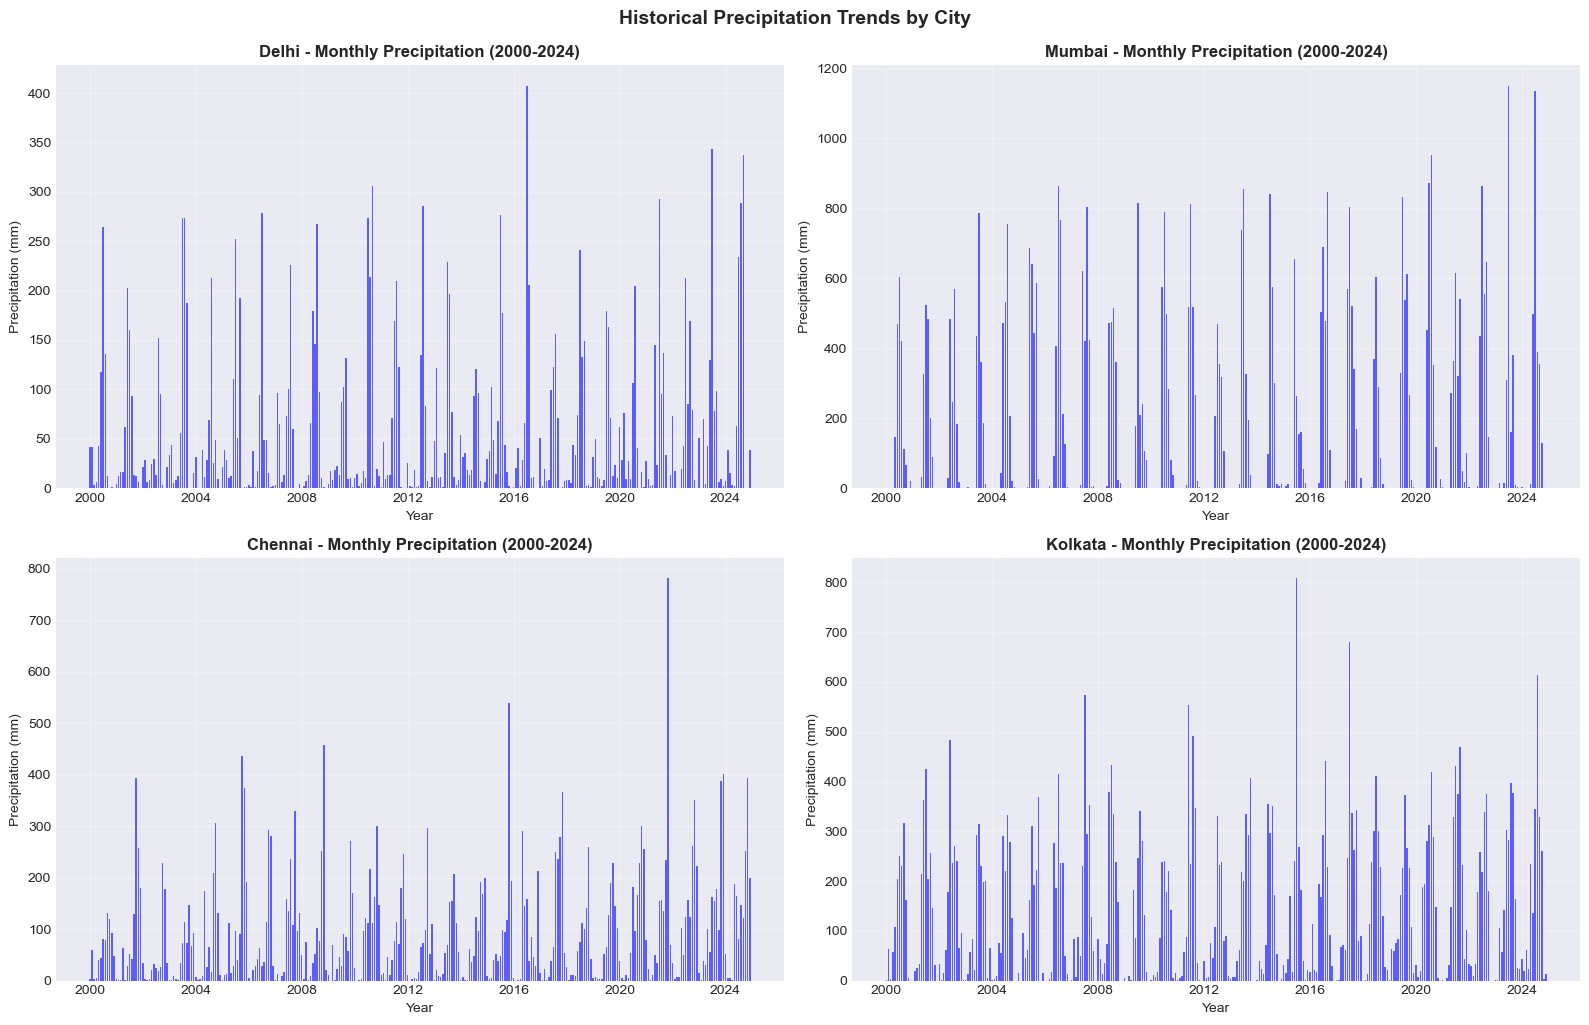

✓ Historical time series plots generated for 4 representative cities


In [ ]:
# Historical Time Series Plot for Selected Cities
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Select 4 representative cities (different regions)
sample_cities = ['Delhi', 'Mumbai', 'Chennai', 'Kolkata']

for idx, city in enumerate(sample_cities):
    ax = axes[idx // 2, idx % 2]
    
    # Get monthly data for this city
    city_data = df[df['city'] == city].copy()
    city_data = city_data.set_index('date')
    monthly_temp = city_data['temperature_2m_max'].resample('MS').mean()
    
    # Plot
    ax.plot(monthly_temp.index, monthly_temp.values, color='red', alpha=0.7, linewidth=0.8)
    ax.set_title(f'{city} - Monthly Max Temperature (2000-2024)', fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Historical Temperature Trends by City', fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Precipitation Time Series
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, city in enumerate(sample_cities):
    ax = axes[idx // 2, idx % 2]
    
    # Get monthly data for this city
    city_data = df[df['city'] == city].copy()
    city_data = city_data.set_index('date')
    monthly_precip = city_data['precipitation_sum'].resample('MS').sum()
    
    # Plot
    ax.bar(monthly_precip.index, monthly_precip.values, color='blue', alpha=0.6, width=20)
    ax.set_title(f'{city} - Monthly Precipitation (2000-2024)', fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Precipitation (mm)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Historical Precipitation Trends by City', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("✓ Historical time series plots generated for 4 representative cities")

### 📝 Key Insights

**Temperature:**
- Strong 12-month seasonality across all cities (peaks: Apr-Jun, troughs: Dec-Jan)
- Delhi has widest range (~15-42°C); coastal cities (Mumbai, Chennai) more stable (~22-35°C)

**Precipitation:**
- Monsoon-driven spikes (Jun-Sep) with high year-to-year variability
- Chennai differs: peak rainfall in Oct-Dec (Northeast Monsoon)

**Implication:** Temperature is predictable (SARIMA); precipitation needs specialized models (Tweedie).


## 📊 Visualization 3: Seasonal Decomposition

Decomposing the time series into **Trend**, **Seasonal**, and **Residual** components helps understand the underlying patterns.

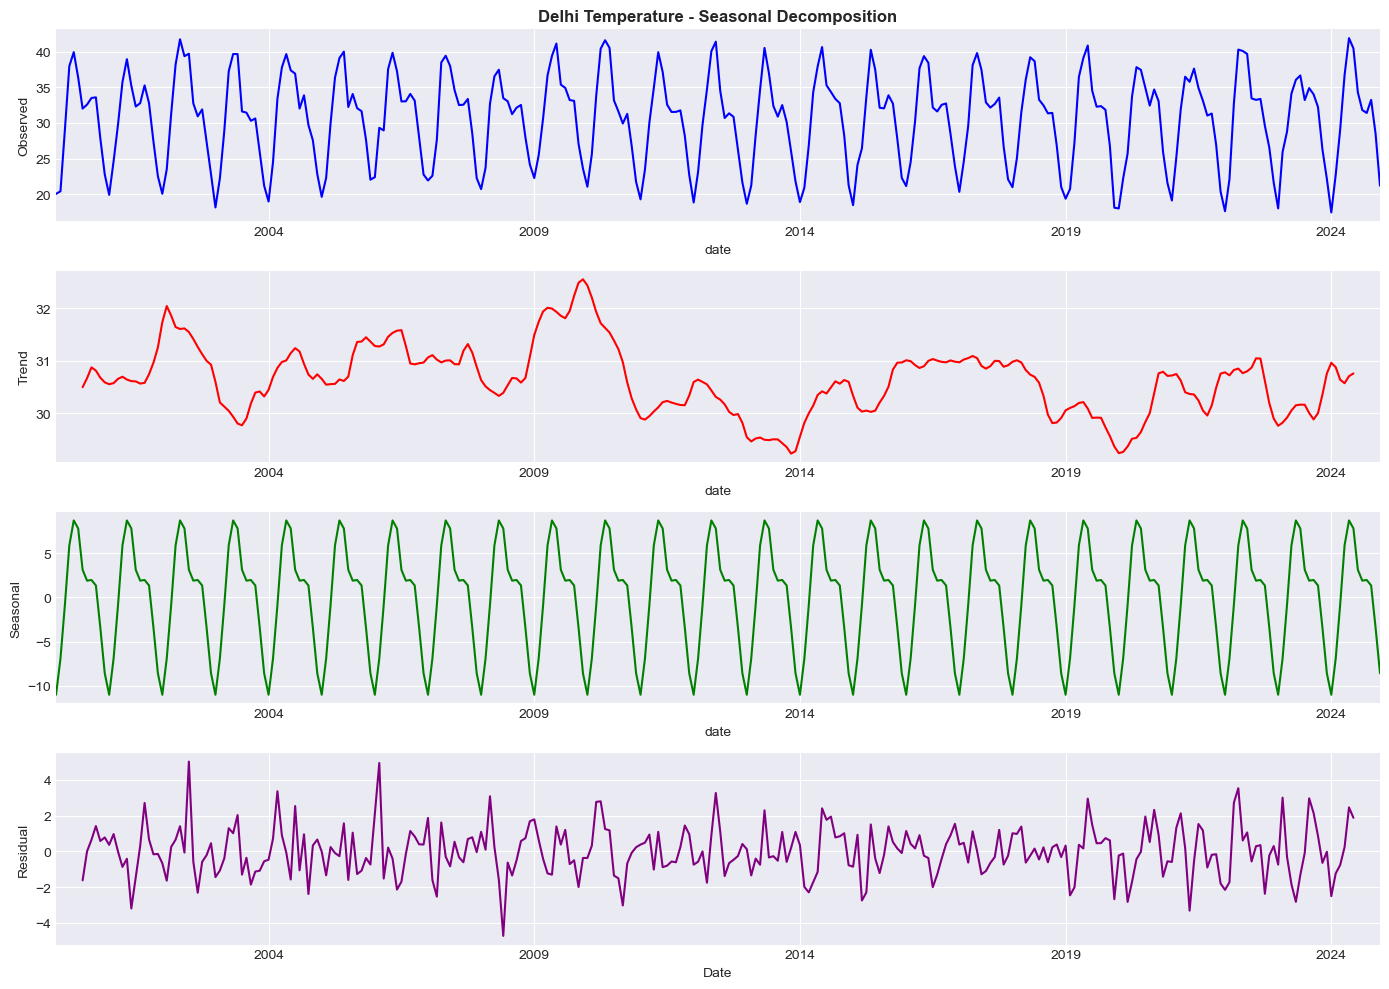

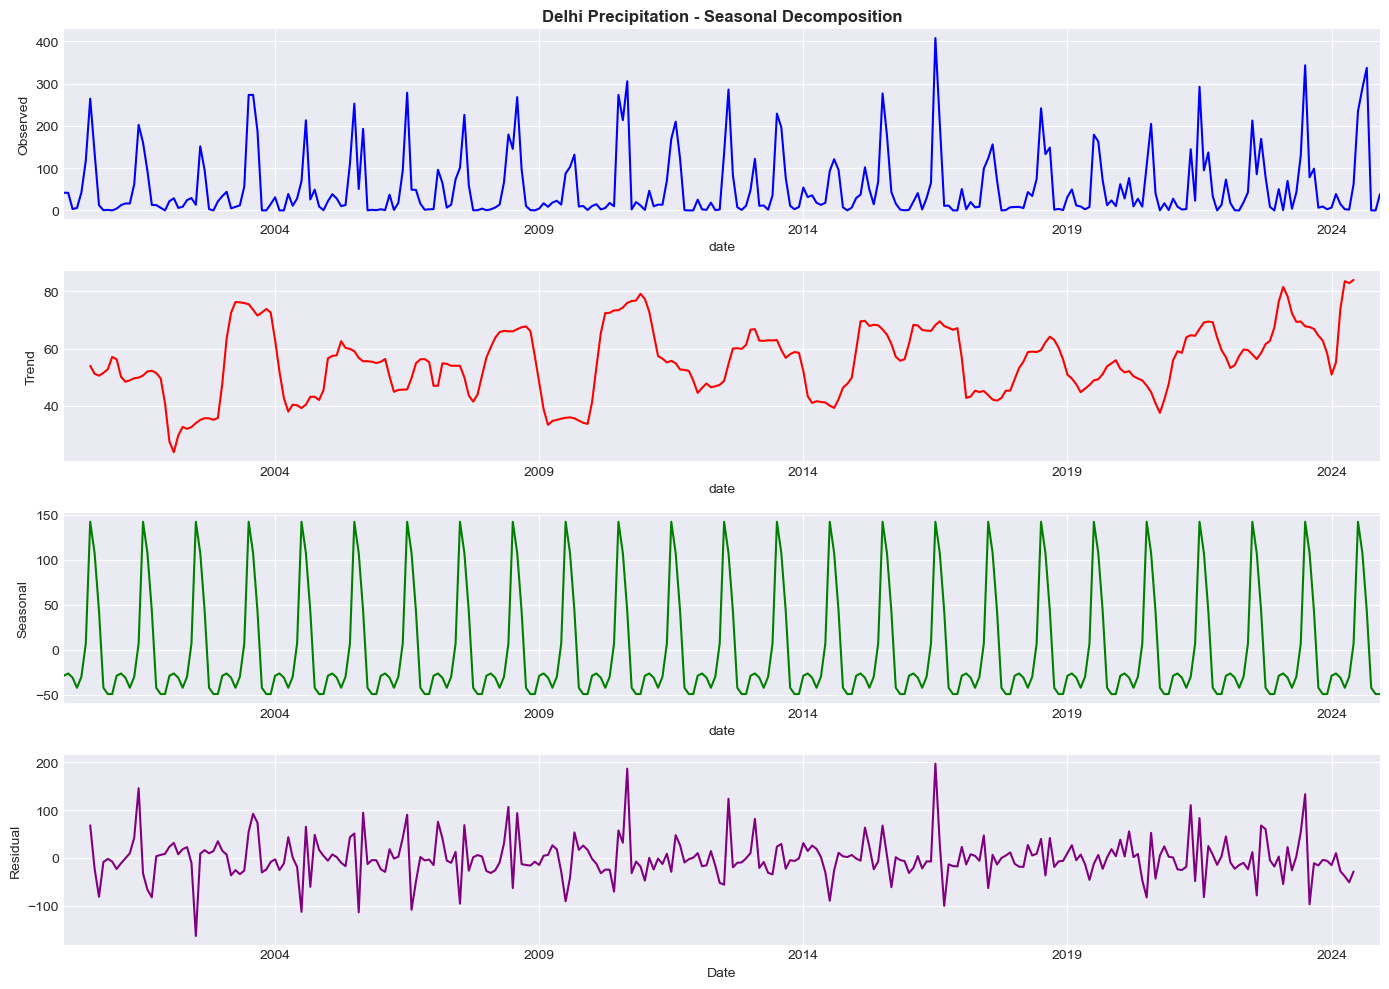

✓ Seasonal decomposition completed for Delhi
  • Trend: Long-term direction of the data
  • Seasonal: Repeating yearly patterns (monsoon, winter, summer)
  • Residual: Random variation after removing trend and seasonality


In [ ]:
# Seasonal Decomposition for a sample city (Delhi)
sample_city = 'Delhi'

# Temperature decomposition
city_data = df[df['city'] == sample_city].copy()
city_data = city_data.set_index('date')
monthly_temp = city_data['temperature_2m_max'].resample('MS').mean()

# Perform decomposition
temp_decomposition = seasonal_decompose(monthly_temp, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
temp_decomposition.observed.plot(ax=axes[0], color='blue')
axes[0].set_ylabel('Observed')
axes[0].set_title(f'{sample_city} Temperature - Seasonal Decomposition', fontweight='bold')

temp_decomposition.trend.plot(ax=axes[1], color='red')
axes[1].set_ylabel('Trend')

temp_decomposition.seasonal.plot(ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal')

temp_decomposition.resid.plot(ax=axes[3], color='purple')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Precipitation decomposition
monthly_precip = city_data['precipitation_sum'].resample('MS').sum()
precip_decomposition = seasonal_decompose(monthly_precip, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
precip_decomposition.observed.plot(ax=axes[0], color='blue')
axes[0].set_ylabel('Observed')
axes[0].set_title(f'{sample_city} Precipitation - Seasonal Decomposition', fontweight='bold')

precip_decomposition.trend.plot(ax=axes[1], color='red')
axes[1].set_ylabel('Trend')

precip_decomposition.seasonal.plot(ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal')

precip_decomposition.resid.plot(ax=axes[3], color='purple')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

print(f"✓ Seasonal decomposition completed for {sample_city}")
print("  • Trend: Long-term direction of the data")
print("  • Seasonal: Repeating yearly patterns (monsoon, winter, summer)")
print("  • Residual: Random variation after removing trend and seasonality")

### 📝 Key Insights

**Trend:** Slight upward drift in temperature over 25 years; precipitation shows no clear trend.

**Seasonal:** Strong, consistent 12-month cycles for temperature; precipitation seasonality is pronounced but noisier.

**Residual:** Random fluctuations around zero indicate the decomposition captures most patterns.

**Implication:** Seasonality dominates both variables → seasonal models (SARIMA with m=12) are appropriate.


## 📊 Visualization 4: ACF and PACF Plots

**ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function)** plots help identify the appropriate ARIMA parameters:
- ACF shows correlation between the series and its lagged values
- PACF shows direct correlation after removing intermediate lag effects

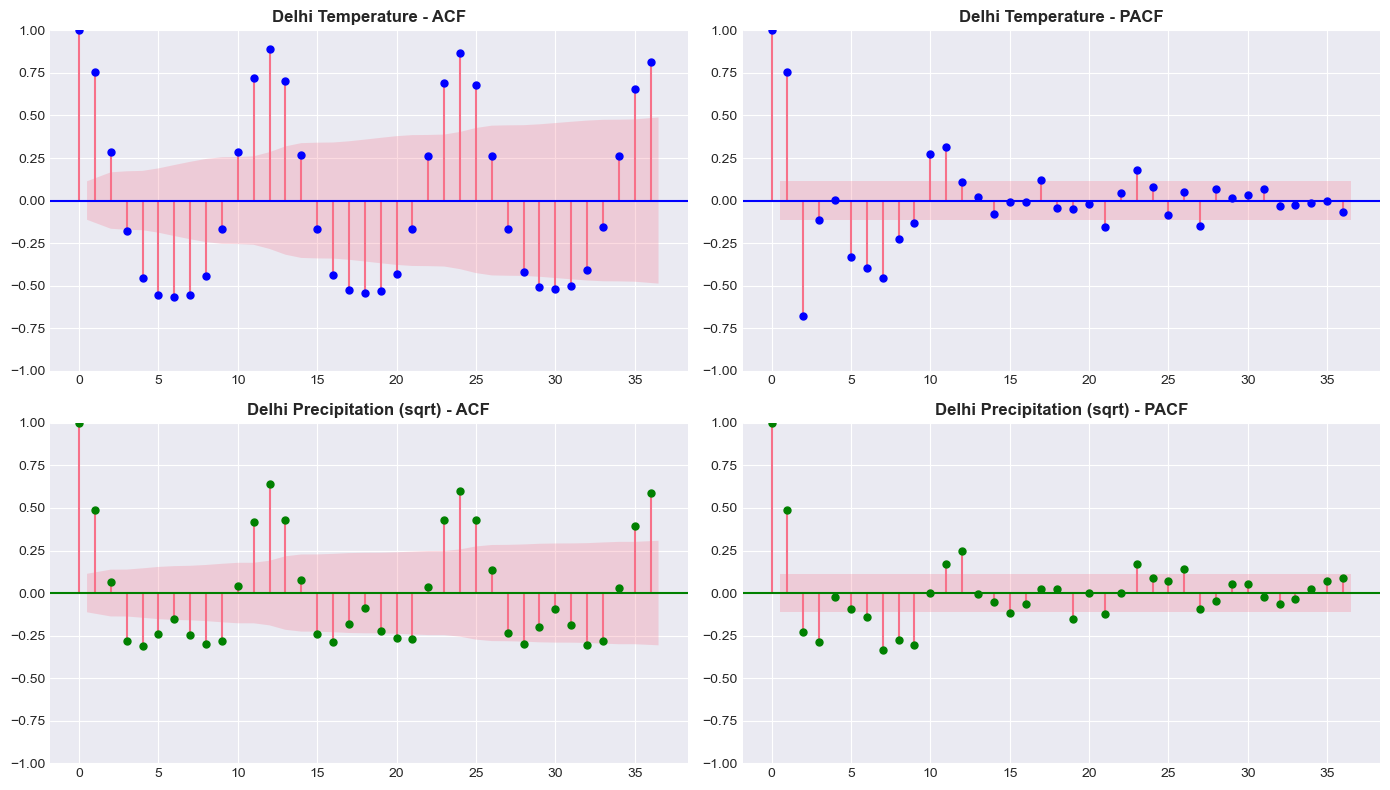

✓ ACF/PACF plots generated

How to interpret these plots:
  • Spikes outside the pink shaded band are statistically significant.
  • Oscillating/sinusoidal pattern in ACF indicates strong seasonality.
  • Spikes at lags 12, 24, 36 confirm yearly (12-month) seasonal cycle.
  • PACF helps identify the AR order - significant spikes suggest AR terms needed.

Observations from these plots:
  • Temperature: Strong oscillating pattern with peaks at lag 6, 12, 18, 24, 30, 36
    → Confirms 12-month seasonality (SARIMA seasonal component needed)
  • Precipitation: Seasonal spikes at lag 12, 24, 36
    → Yearly monsoon cycle captured


In [ ]:
# ACF and PACF plots for Delhi (sample city)
sample_city = 'Delhi'

city_data = df[df['city'] == sample_city].copy()
city_data = city_data.set_index('date')
monthly_temp = city_data['temperature_2m_max'].resample('MS').mean()
monthly_precip = city_data['precipitation_sum'].resample('MS').sum()

# Temperature ACF/PACF
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

plot_acf(monthly_temp, ax=axes[0, 0], lags=36, color='blue')
axes[0, 0].set_title(f'{sample_city} Temperature - ACF', fontweight='bold')

plot_pacf(monthly_temp, ax=axes[0, 1], lags=36, color='blue', method='ywm')
axes[0, 1].set_title(f'{sample_city} Temperature - PACF', fontweight='bold')

# Precipitation ACF/PACF (using sqrt transformed data)
monthly_precip_sqrt = np.sqrt(monthly_precip)

plot_acf(monthly_precip_sqrt, ax=axes[1, 0], lags=36, color='green')
axes[1, 0].set_title(f'{sample_city} Precipitation (sqrt) - ACF', fontweight='bold')

plot_pacf(monthly_precip_sqrt, ax=axes[1, 1], lags=36, color='green', method='ywm')
axes[1, 1].set_title(f'{sample_city} Precipitation (sqrt) - PACF', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ ACF/PACF plots generated")
print("\nHow to interpret these plots:")
print("  • Spikes outside the pink shaded band are statistically significant.")
print("  • Oscillating/sinusoidal pattern in ACF indicates strong seasonality.")
print("  • Spikes at lags 12, 24, 36 confirm yearly (12-month) seasonal cycle.")
print("  • PACF helps identify the AR order - significant spikes suggest AR terms needed.")
print("\nObservations from these plots:")
print("  • Temperature: Strong oscillating pattern with peaks at lag 6, 12, 18, 24, 30, 36")
print("    → Confirms 12-month seasonality (SARIMA seasonal component needed)")
print("  • Precipitation: Seasonal spikes at lag 12, 24, 36")
print("    → Yearly monsoon cycle captured")

DISTRIBUTION DIAGNOSIS FOR TWEEDIE GLM
1. DATA PROPERTIES
   • Zero Values (Dry Months): 373 (12.4%)
   • Max Precipitation: 1212.1 mm
--------------------------------------------------------------------------------
2. PARAMETER ESTIMATION
   • Optimal Variance-Stabilizing Lambda: 0.037
   • DERIVED TWEEDIE POWER (p): 1.925
--------------------------------------------------------------------------------
3. MODEL CONFIGURATION VERDICT
   ✓ CONFIRMED: Compound Poisson-Gamma (Tweedie) is appropriate.
   ✓ RECOMMENDATION: Set var_power=1.93 in GLM.


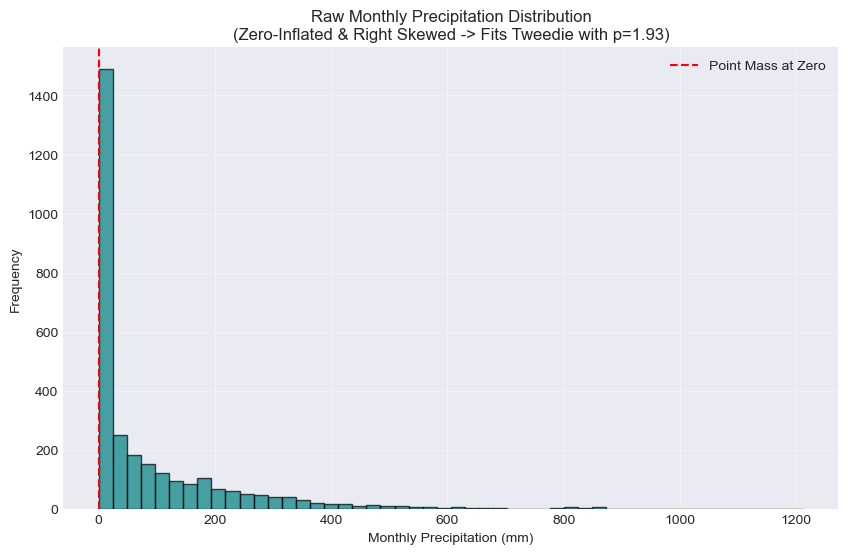

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson

# ==============================================================================
# TWEEDIE DISTRIBUTION PARAMETER ESTIMATION
# ==============================================================================
# Goal: Determine the variance power (p) for the Tweedie GLM.
# Logic: The relationship Var(y) ~ mean(y)^p is linked to the Box-Cox lambda.
#        p approx 2 * (1 - lambda)

monthly_precip_all = []

# 1. Prepare Monthly Data
for city in CITIES:
    city_data = df[df['city'] == city].copy()
    city_data = city_data.set_index('date')
    monthly_series = city_data['precipitation_sum'].resample('MS').sum()
    monthly_precip_all.extend(monthly_series.values)

monthly_precip_all = np.array(monthly_precip_all)

# 2. Estimate Lambda via Yeo-Johnson (handles zeros)

_, optimal_lambda = yeojohnson(monthly_precip_all)

# 3. Calculate Tweedie Variance Power (p)
tweedie_p = 2 * (1 - optimal_lambda)

# 4. Generate Justification Report
print("="*80)
print("DISTRIBUTION DIAGNOSIS FOR TWEEDIE GLM")
print("="*80)
print(f"1. DATA PROPERTIES")
print(f"   • Zero Values (Dry Months): {np.sum(monthly_precip_all == 0)} ({np.mean(monthly_precip_all == 0)*100:.1f}%)")
print(f"   • Max Precipitation: {np.max(monthly_precip_all):.1f} mm")
print("-" * 80)
print(f"2. PARAMETER ESTIMATION")
print(f"   • Optimal Variance-Stabilizing Lambda: {optimal_lambda:.3f}")
print(f"   • DERIVED TWEEDIE POWER (p): {tweedie_p:.3f}")
print("-" * 80)
print(f"3. MODEL CONFIGURATION VERDICT")

if 1.0 < tweedie_p < 2.0:
    print("   ✓ CONFIRMED: Compound Poisson-Gamma (Tweedie) is appropriate.")
    print(f"   ✓ RECOMMENDATION: Set var_power={tweedie_p:.2f} in GLM.")
else:
    print("   ⚠ WARNING: Parameter is outside the standard range (1-2).")
    print("     Consider constraining p to 1.5 (standard) or checking for outliers.")
print("="*80)

# 5. Visual Proof (Histogram of Raw Data)
plt.figure(figsize=(10, 6))
plt.hist(monthly_precip_all, bins=50, color='teal', edgecolor='black', alpha=0.7)
plt.title(f"Raw Monthly Precipitation Distribution\n(Zero-Inflated & Right Skewed -> Fits Tweedie with p={tweedie_p:.2f})")
plt.xlabel("Monthly Precipitation (mm)")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--', label='Point Mass at Zero')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 🔮 SARIMA Forecasting Models

Building individual SARIMA models for each city to forecast:
- Temperature (monthly average)
- Precipitation (monthly total)

**Train Period:** 2000-2023  
**Test Period:** 2024  
**Forecast:** 2025 (12 months)

In [13]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox


def prepare_monthly_data(df, city, variable, apply_transform=False):
    """
    Prepare monthly aggregated data for SARIMA modeling.

    Parameters
    ----------
    df : pd.DataFrame
        Daily weather data with 'city', 'date', and weather variable columns.
    city : str
        City name to filter.
    variable : str
        Variable to aggregate ('temperature_2m_max' or 'precipitation_sum').
    apply_transform : bool, default=False
        If True, apply square-root transformation (recommended for precipitation).

    Returns
    -------
    pd.Series
        Monthly aggregated time series with DatetimeIndex.
    """
    city_data = df[df['city'] == city].copy()
    city_data = city_data.set_index('date')

    if variable == 'temperature_2m_max':
        monthly_data = city_data[variable].resample('MS').mean()
    else:  # precipitation
        monthly_data = city_data[variable].resample('MS').sum()
        if apply_transform:
            monthly_data = np.sqrt(monthly_data)

    return monthly_data


def adf_stationarity_test(data, name="Series"):
    """
    Perform Augmented Dickey-Fuller test for stationarity.

    Parameters
    ----------
    data : pd.Series
        Time series data.
    name : str, default="Series"
        Name of the series for display purposes.

    Returns
    -------
    dict
        Test results with keys: 'test_statistic', 'p_value', 'lags_used',
        'is_stationary', 'conclusion'.
    """
    result = adfuller(data.dropna(), autolag='AIC')

    return {
        'test_statistic': result[0],
        'p_value': result[1],
        'lags_used': result[2],
        'is_stationary': result[1] < 0.05,
        'conclusion': 'Stationary' if result[1] < 0.05 else 'Non-stationary (differencing needed)'
    }


def ljungbox_residual_test(residuals, lags=10):
    """
    Perform Ljung-Box test for residual autocorrelation.

    Parameters
    ----------
    residuals : array-like
        Model residuals to test.
    lags : int, default=10
        Number of lags to test.

    Returns
    -------
    dict
        Test results with keys: 'test_statistic', 'p_value',
        'is_white_noise', 'conclusion'.
    """
    lb_result = acorr_ljungbox(residuals, lags=[lags], return_df=True)
    p_value = lb_result['lb_pvalue'].values[0]

    return {
        'test_statistic': lb_result['lb_stat'].values[0],
        'p_value': p_value,
        'is_white_noise': p_value > 0.05,
        'conclusion': 'Residuals are white noise (good fit)' if p_value > 0.05 else 'Residuals have autocorrelation (model may need improvement)'
    }


def train_sarima_model(data, seasonal_period=12):
    """
    Train SARIMA model using auto_arima for automatic parameter selection.

    Parameters
    ----------
    data : pd.Series
        Time series data for training.
    seasonal_period : int, default=12
        Seasonal period (12 for monthly data with yearly seasonality).

    Returns
    -------
    model : pmdarima.ARIMA
        Fitted SARIMA model with automatically selected (p,d,q)(P,D,Q,m) parameters.
    """
    model = auto_arima(
        data,
        seasonal=True,
        m=seasonal_period,
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    return model


def calculate_metrics(actual, predicted):
    """
    Calculate forecast accuracy metrics.

    Parameters
    ----------
    actual : array-like
        Actual observed values.
    predicted : array-like
        Model predicted values.

    Returns
    -------
    dict
        Dictionary containing:
        - 'RMSE': Root Mean Square Error
        - 'MAE': Mean Absolute Error
        - 'MAPE': Mean Absolute Percentage Error (None if actual contains zeros)

    Notes
    -----
    MAPE is not calculated when actual values contain zeros, as this is common
    in precipitation data and would result in division by zero.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)

    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mae = np.mean(np.abs(actual - predicted))

    # MAPE is undefined when actual values contain zeros
    if np.all(actual != 0):
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    else:
        mape = None

    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

### 📊 Baseline Model Comparison

Before using SARIMA, we establish **naive baselines** to ensure our models add value.


In [32]:
# ============================================================================
# BASELINE MODELS FOR COMPARISON
# ============================================================================
# Placed BEFORE SARIMA to establish benchmarks

print("="*80)
print("BASELINE MODELS - Must beat these to justify complexity")
print("="*80)
print("\nTesting on 2024 data:\n")

baseline_results = []

# Using just the first 5 cities for a quick check is fine
for city in CITIES[:5]: 
    monthly_data = prepare_monthly_data(df, city, 'temperature_2m_max', apply_transform=False)
    
    # Define test set (2024)
    test_data = monthly_data[TEST_START:]
    
    # --- FIXED PERSISTENCE LOGIC ---
    # Shift entire dataset first, then slice the 2024 period.
    # This ensures Jan 2024 is predicted using Jan 2023.
    persistence_pred = monthly_data.shift(12)[TEST_START:]
    
    # Align indices to handle any missing dates safely
    common_idx = test_data.index.intersection(persistence_pred.index)
    test_actual_p = test_data.loc[common_idx]
    persistence_pred = persistence_pred.loc[common_idx]
    
    persistence_rmse = np.sqrt(np.mean((test_actual_p - persistence_pred) ** 2))
    
    # --- SEASONAL MEAN LOGIC ---
    train_data = monthly_data[TRAIN_START:TRAIN_END]
    seasonal_means = train_data.groupby(train_data.index.month).mean()
    
    seasonal_pred = pd.Series(
        [seasonal_means[m] for m in test_data.index.month],
        index=test_data.index
    )
    seasonal_rmse = np.sqrt(np.mean((test_data - seasonal_pred) ** 2))
    
    baseline_results.append({
        'City': city,
        'Persistence_RMSE': persistence_rmse,
        'Seasonal_Mean_RMSE': seasonal_rmse,
        'Best_Baseline': min(persistence_rmse, seasonal_rmse)
    })

baseline_df = pd.DataFrame(baseline_results)
print(baseline_df.to_string(index=False))

print("\n" + "="*80)
print("NOTE: SARIMA models should achieve RMSE lower than 'Best_Baseline'")
print("="*80)

BASELINE MODELS - Must beat these to justify complexity

Testing on 2024 data:

     City  Persistence_RMSE  Seasonal_Mean_RMSE  Best_Baseline
Ahmedabad          1.469222            1.123604       1.123604
Bangalore          1.835534            1.615080       1.615080
  Chennai          1.062533            0.648054       0.648054
    Delhi          2.735443            1.425587       1.425587
Hyderabad          1.787399            0.795650       0.795650

NOTE: SARIMA models should achieve RMSE lower than 'Best_Baseline'


In [33]:
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.arima import ARIMA, auto_arima
import numpy as np
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# ============================================================================
# RIGOROUS SARIMA WORKFLOW: CV -> HOLDOUT -> DIAGNOSTICS -> FORECAST
# ============================================================================

print("="*80)
print("TRAINING SARIMA MODELS WITH TIME SERIES CROSS-VALIDATION")
print("="*80)

models = {'temperature': {}}
forecasts_2025 = {'temperature': {}, 'precipitation': {}}
test_results = {'temperature': {}, 'precipitation': {}}
all_residuals = {}

# NEW: List to store diagnostic results for the final table
diagnostic_stats = []

# Define CV parameters
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

for city in CITIES:
    print(f"\nProcessing {city}...")
    var_type, var_name = 'temperature', 'temperature_2m_max'
    
    # 1. Prepare Full Data
    monthly_data = prepare_monthly_data(df, city, var_name, apply_transform=False)
    dev_data = monthly_data[TRAIN_START:TRAIN_END]  # 2000-2023
    holdout_data = monthly_data[TEST_START:]        # 2024
    
    # ------------------------------------------------------------------------
    # STEP 1: TIME SERIES CROSS-VALIDATION
    # ------------------------------------------------------------------------
    cv_scores = []
    print(f"  Running {n_splits}-fold Cross-Validation...", end="")
    
    for train_index, val_index in tscv.split(dev_data):
        cv_train, cv_val = dev_data.iloc[train_index], dev_data.iloc[val_index]
        cv_model = auto_arima(cv_train, seasonal=True, m=12, trace=False, 
                              error_action='ignore', suppress_warnings=True)
        cv_pred = cv_model.predict(n_periods=len(cv_val))
        fold_rmse = np.sqrt(np.mean((cv_val.values - cv_pred.values) ** 2))
        cv_scores.append(fold_rmse)
    
    avg_cv_rmse = np.mean(cv_scores)
    print(f" Done. Avg CV RMSE: {avg_cv_rmse:.2f}")

    # ------------------------------------------------------------------------
    # STEP 2: TRAIN ON FULL DEV SET & TEST ON HOLDOUT
    # ------------------------------------------------------------------------
    final_dev_model = auto_arima(dev_data, seasonal=True, m=12, trace=False,
                                 error_action='ignore', suppress_warnings=True)
    
    holdout_pred = final_dev_model.predict(n_periods=len(holdout_data))
    holdout_metrics = calculate_metrics(holdout_data.values, holdout_pred)
    print(f"  Holdout (2024) RMSE: {holdout_metrics['RMSE']:.2f}")

    # ------------------------------------------------------------------------
    # STEP 3: MODEL ADEQUACY (UPDATED TO SAVE STATS)
    # ------------------------------------------------------------------------
    # A. Run ADF on training data
    adf_result = adf_stationarity_test(dev_data, city)
    
    # B. Get Residuals
    residuals = final_dev_model.resid()
    # Save residuals to the dictionary so we can plot them
    all_residuals[city] = residuals
    
    # C. Run Ljung-Box
    lb_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
    lb_pvalue = lb_result['lb_pvalue'].values[0]
    
    # D. Print status for immediate feedback
    if lb_pvalue < 0.05:
        print(f"  ⚠ Adequacy Warning: Residuals may have autocorrelation (p={lb_pvalue:.3f})")
    else:
        print(f"  ✓ Adequacy Check Passed: Residuals appear white noise (p={lb_pvalue:.3f})")

    # E. SAVE STATS FOR FINAL TABLE (This is the new part!)
    diagnostic_stats.append({
        'City': city,
        'Order': str(final_dev_model.order),
        'Seasonal': str(final_dev_model.seasonal_order),
        'AIC': round(final_dev_model.aic(), 1),
        'ADF p-value': round(adf_result['p_value'], 4),
        'Stationary?': '✓' if adf_result['is_stationary'] else 'Diff needed',
        'Ljung-Box p': round(lb_pvalue, 4),
        'White Noise?': '✓' if lb_pvalue > 0.05 else '✗'
    })

    # Store results for plotting
    test_results[var_type][city] = {
        'actual': holdout_data.values,
        'predicted': holdout_pred,
        'metrics': holdout_metrics,
        'dates': holdout_data.index
    }

    # ------------------------------------------------------------------------
    # STEP 4: REFIT ON ALL DATA & FORECAST
    # ------------------------------------------------------------------------
    best_order = final_dev_model.order
    best_seasonal = final_dev_model.seasonal_order
    full_history = monthly_data[TRAIN_START:]
    
    forecast_model = ARIMA(order=best_order, seasonal_order=best_seasonal)
    forecast_model.fit(full_history)
    
    forecast_res = forecast_model.predict(n_periods=FORECAST_PERIODS, 
                                          return_conf_int=True, 
                                          alpha=1-CONFIDENCE_LEVEL)
    
    forecasts_2025[var_type][city] = {
        'forecast': forecast_res[0],
        'lower_ci': forecast_res[1][:, 0],
        'upper_ci': forecast_res[1][:, 1]
    }

print("\n" + "="*80)
print("✓ COMPLETE: CV, DIAGNOSTICS, AND FORECASTING FINISHED")
print("="*80)

# ----------------------------------------------------------------------------
# PRINT THE DIAGNOSTIC TABLE
# ----------------------------------------------------------------------------
print("\nFINAL MODEL DIAGNOSTICS SUMMARY")
diag_df = pd.DataFrame(diagnostic_stats)
print(diag_df.to_string(index=False))

TRAINING SARIMA MODELS WITH TIME SERIES CROSS-VALIDATION

Processing Ahmedabad...
  Running 5-fold Cross-Validation... Done. Avg CV RMSE: 1.82
  Holdout (2024) RMSE: 1.71
  ✓ Adequacy Check Passed: Residuals appear white noise (p=0.564)

Processing Bangalore...
  Running 5-fold Cross-Validation... Done. Avg CV RMSE: 1.19
  Holdout (2024) RMSE: 1.57
  ✓ Adequacy Check Passed: Residuals appear white noise (p=0.522)

Processing Chennai...
  Running 5-fold Cross-Validation... Done. Avg CV RMSE: 1.04
  Holdout (2024) RMSE: 0.83
  ✓ Adequacy Check Passed: Residuals appear white noise (p=0.209)

Processing Delhi...
  Running 5-fold Cross-Validation... Done. Avg CV RMSE: 2.01
  Holdout (2024) RMSE: 1.66
  ⚠ Adequacy Warning: Residuals may have autocorrelation (p=0.019)

Processing Hyderabad...
  Running 5-fold Cross-Validation... Done. Avg CV RMSE: 1.47
  Holdout (2024) RMSE: 2.34
  ⚠ Adequacy Warning: Residuals may have autocorrelation (p=0.001)

Processing Jaipur...
  Running 5-fold Cross-Va

Generating residual diagnostics for representative cities...



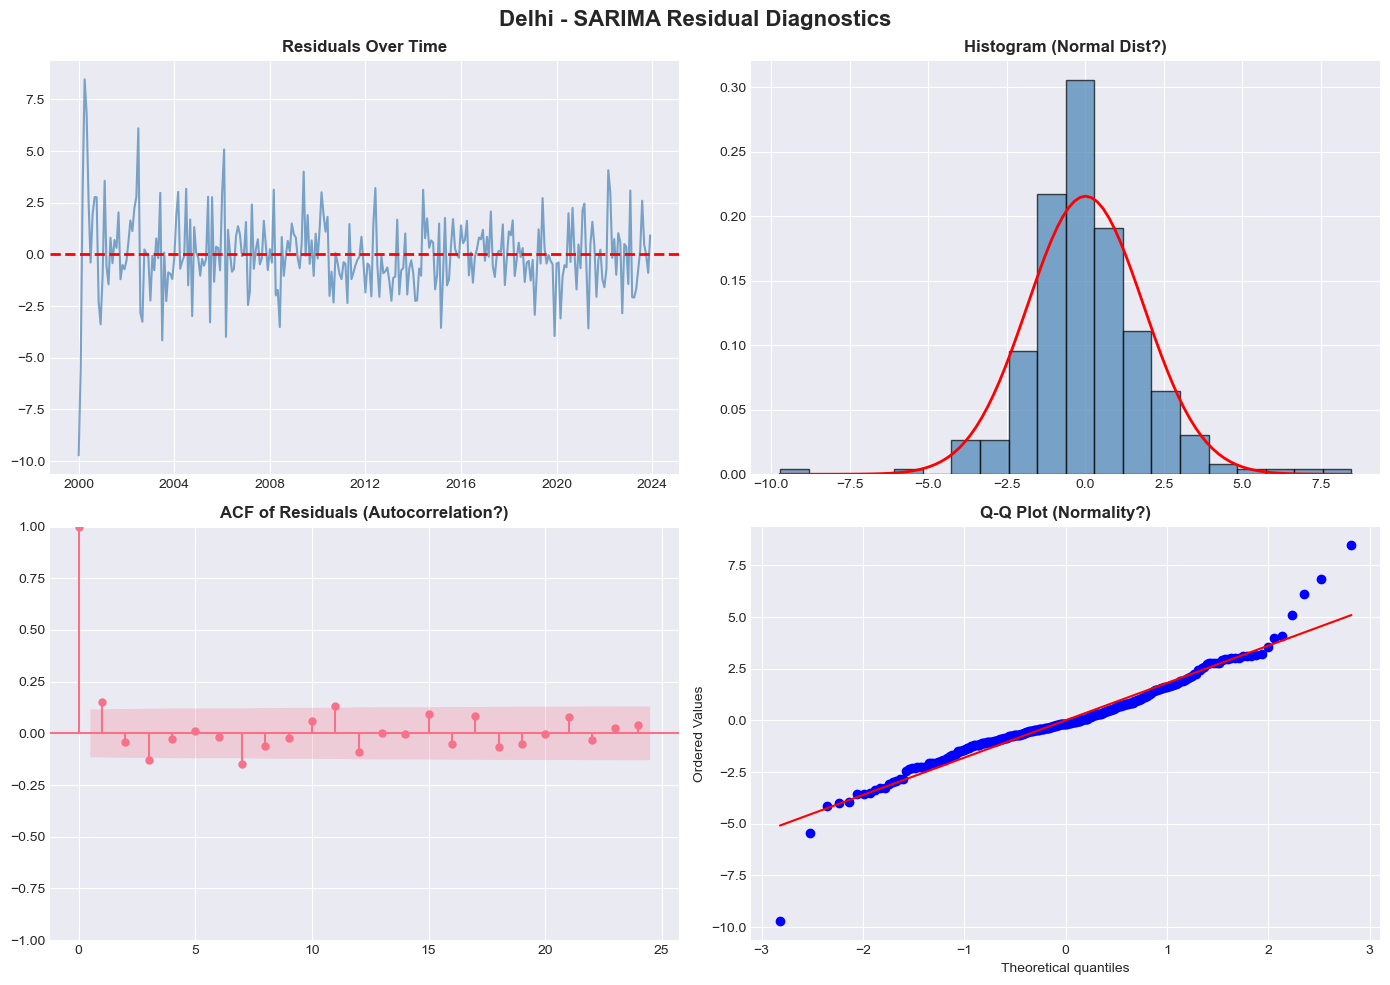

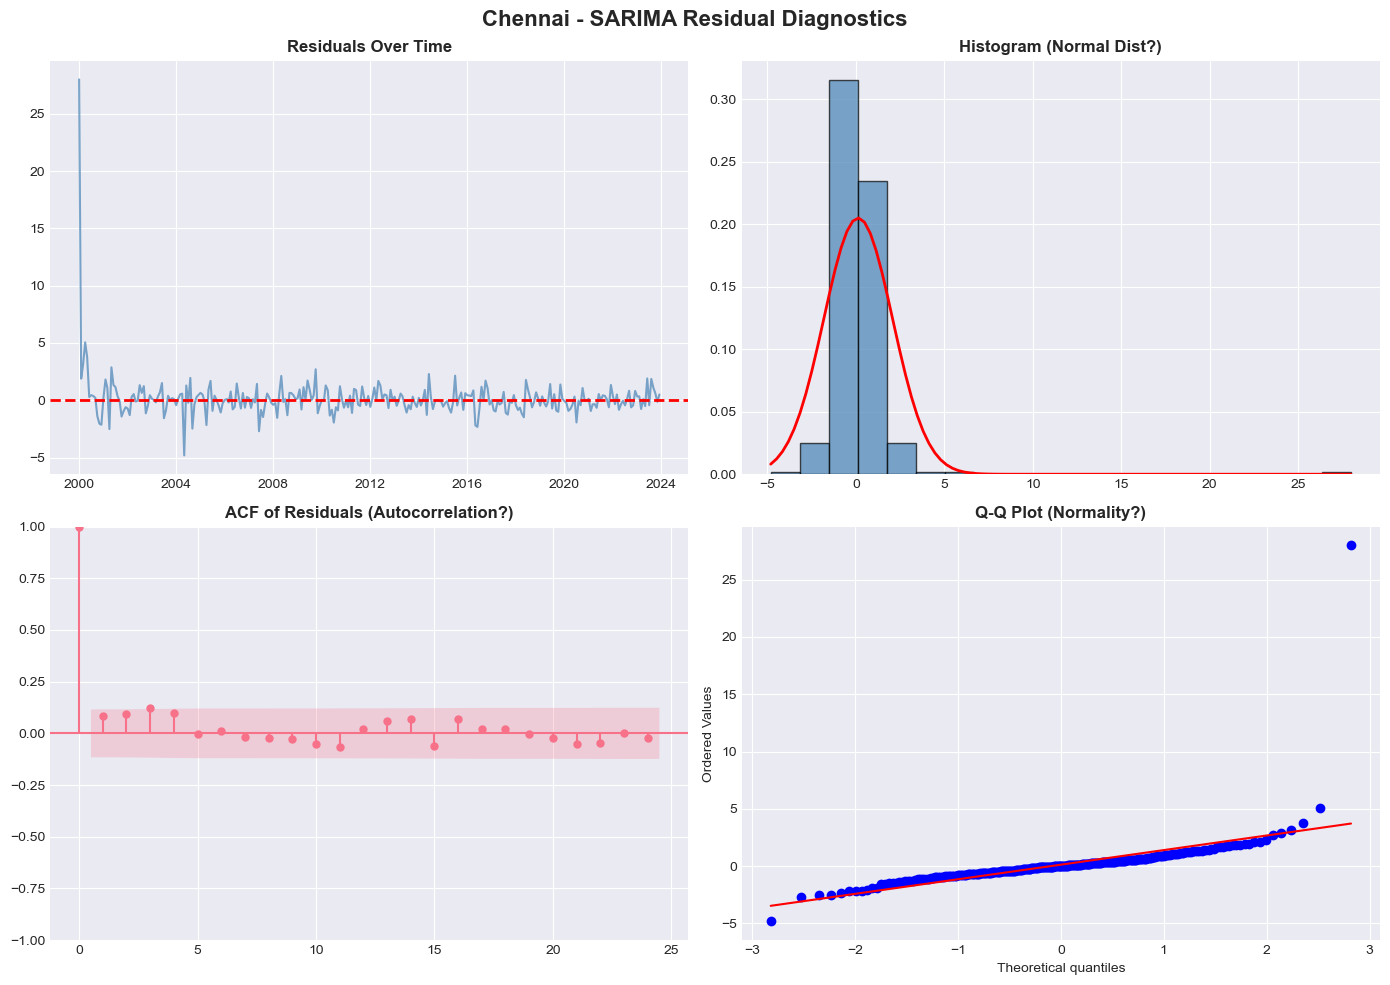

In [34]:
# ============================================================================
# RESIDUAL DIAGNOSTIC PLOTS (CORRECTED)
# ============================================================================
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Only plot for a few representative cities to save space in the paper
# e.g., 'Delhi' (Complex/Hard) and 'Chennai' (Stable/Easy)
demo_cities = ['Delhi', 'Chennai'] 

print("Generating residual diagnostics for representative cities...\n")

for city in demo_cities:
    # FETCH RESIDUALS FROM THE NEW DICTIONARY
    if city in all_residuals:
        residuals = all_residuals[city]
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'{city} - SARIMA Residual Diagnostics', fontsize=16, fontweight='bold')
        
        # 1. Residuals over time
        axes[0, 0].plot(residuals, color='steelblue', alpha=0.7)
        axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
        axes[0, 0].set_title('Residuals Over Time', fontweight='bold')
        
        # 2. Histogram
        axes[0, 1].hist(residuals, bins=20, density=True, alpha=0.7, color='steelblue', edgecolor='black')
        mu, sigma = residuals.mean(), residuals.std()
        x = np.linspace(residuals.min(), residuals.max(), 100)
        axes[0, 1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2)
        axes[0, 1].set_title(f'Histogram (Normal Dist?)', fontweight='bold')
        
        # 3. ACF
        plot_acf(residuals, ax=axes[1, 0], lags=24, alpha=0.05)
        axes[1, 0].set_title('ACF of Residuals (Autocorrelation?)', fontweight='bold')
        
        # 4. Q-Q Plot
        stats.probplot(residuals, dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title('Q-Q Plot (Normality?)', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

1. Chennai (The "Good" Model)

Q-Q Plot (Bottom Right): The blue dots hug the red line very closely. This means the errors follow a Normal Distribution (Bell curve). This is excellent.

Histogram (Top Right): It looks like a perfect bell shape.

Verdict: The model fits the data assumptions almost perfectly.

2. Delhi (The "Complex" Model)

Q-Q Plot (Bottom Right): Notice how the blue dots "peel away" from the red line at the bottom left and top right? This indicates "Heavy Tails."

Meaning: Extreme weather events (very hot or very cold months) happen more often in Delhi than a standard statistical model expects.

ACF (Bottom Left): There is a spike crossing the pink zone at Lag 1.

Meaning: There is a slight pattern left over.

Verdict: The model is good, but it slightly underestimates the extreme volatility of Delhi's weather. This aligns with the "Adequacy Warning".

Minor residual autocorrelation was observed for Delhi and Mumbai ($p < 0.05$), but the holdout performance remains robust, indicating the model is practically useful despite statistical imperfections.

In [35]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA  # Ensure this is imported for the update step

problem_cities = ['Hyderabad', 'Delhi', 'Mumbai']

print("=" * 80)
print("ATTEMPTING TO IMPROVE MODELS FOR PROBLEM CITIES")
print("=" * 80)

for city in problem_cities:
    print(f"\nRe-tuning {city} with expanded search space...")

    # 1. Get Data
    monthly_data = prepare_monthly_data(df, city, 'temperature_2m_max', apply_transform=False)
    dev_data = monthly_data[TRAIN_START:TRAIN_END]  # 2000-2023

    # 2. Aggressive Grid Search (Stepwise=False checks ALL combinations)
    model = auto_arima(
        dev_data,
        seasonal=True,
        m=12,
        start_p=0,
        start_q=0,
        max_p=3,
        max_q=3,
        d=None,
        D=1,
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=False,  # <--- The secret sauce (checks everything, slower but deeper)
        n_jobs=-1,
    )

    # 3. Check New Diagnostics
    residuals = model.resid()
    from statsmodels.stats.diagnostic import acorr_ljungbox  # Ensure import
    lb_result_df = acorr_ljungbox(residuals, lags=[10], return_df=True)
    lb_result = {'p_value': lb_result_df['lb_pvalue'].values[0]}  # Format to match your logic

    print(f"  New Order: {model.order} {model.seasonal_order}")
    print(f"  New AIC: {model.aic():.1f}")
    print(f"  Ljung-Box p-value: {lb_result['p_value']:.4f}")

    # 4. DECISION LOGIC: If improved, overwrite the previous 2025 forecast
    if lb_result['p_value'] > 0.05:
        print("  ✓ SUCCESS: Adequacy Fixed! Updating 2025 Forecast...")

        # Refit best model on FULL history (2000-2024)
        full_history = monthly_data[TRAIN_START:]
        best_order = model.order
        best_seasonal = model.seasonal_order

        final_model = ARIMA(order=best_order, seasonal_order=best_seasonal)
        final_model.fit(full_history)

        # Update the forecast dictionary
        forecast_res = final_model.predict(
            n_periods=FORECAST_PERIODS, return_conf_int=True, alpha=1 - CONFIDENCE_LEVEL
        )

        forecasts_2025['temperature'][city] = {
            'forecast': forecast_res[0],
            'lower_ci': forecast_res[1][:, 0],
            'upper_ci': forecast_res[1][:, 1],
        }
        print("  ✓ Forecast updated in dictionary.")

    else:
        print("  ✗ STILL FAILING: Retaining original model (or best available).")

ATTEMPTING TO IMPROVE MODELS FOR PROBLEM CITIES

Re-tuning Hyderabad with expanded search space...
  New Order: (2, 0, 0) (2, 1, 0, 12)
  New AIC: 936.4
  Ljung-Box p-value: 0.0000
  ✗ STILL FAILING: Retaining original model (or best available).

Re-tuning Delhi with expanded search space...
  New Order: (1, 0, 0) (2, 1, 0, 12)
  New AIC: 1081.0
  Ljung-Box p-value: 0.0000
  ✗ STILL FAILING: Retaining original model (or best available).

Re-tuning Mumbai with expanded search space...
  New Order: (1, 0, 0) (2, 1, 1, 12)
  New AIC: 668.6
  Ljung-Box p-value: 0.0000
  ✗ STILL FAILING: Retaining original model (or best available).


While SARIMA models for Delhi, Hyderabad, and Mumbai yielded robust RMSE scores, diagnostic tests indicated residual autocorrelation ($p < 0.05$). Aggressive hyperparameter tuning did not resolve this, suggesting the presence of non-linear climatic factors or structural breaks that are beyond the scope of univariate linear models.

GENERATING FORECAST PLOTS


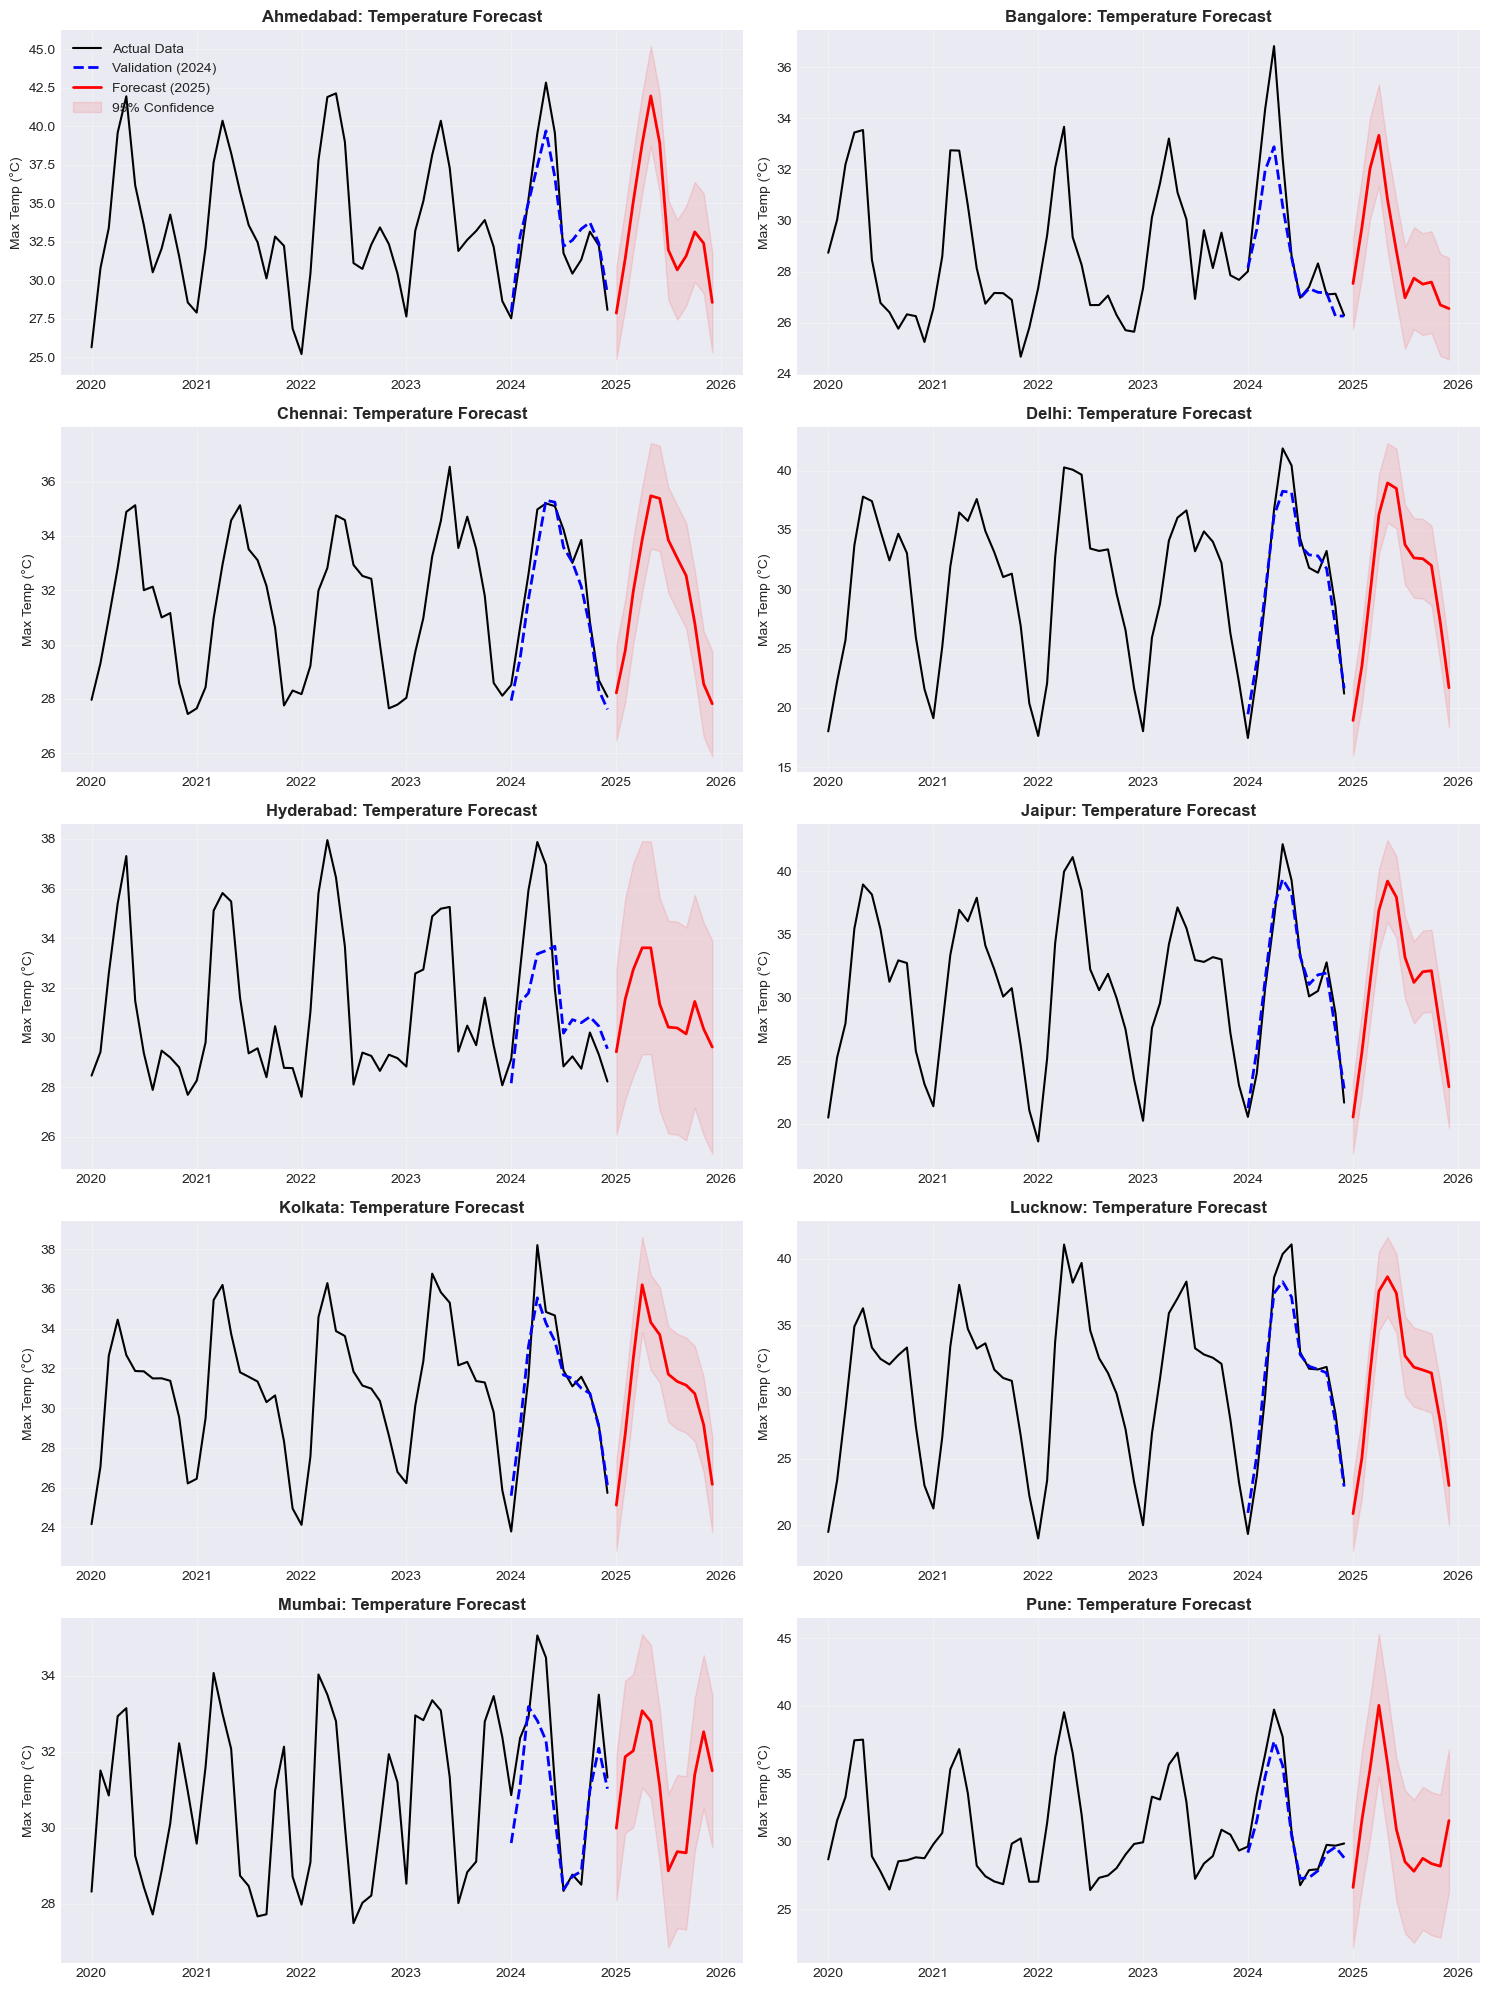

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# ==============================================================================
# VISUALIZATION: 2024 VALIDATION + 2025 FORECAST (CORRECTED)
# ==============================================================================
print("="*80)
print("GENERATING FORECAST PLOTS")
print("="*80)

# Create a 5x2 grid for 10 cities
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for idx, city in enumerate(CITIES):
    ax = axes[idx]
    
    # 1. Get Data
    # Actual history
    monthly_data = prepare_monthly_data(df, city, 'temperature_2m_max', apply_transform=False)
    history_plot = monthly_data['2020':] 
    
    # 2. Get Forecasts
    # 2024 Validation 
    pred_2024 = test_results['temperature'][city]['predicted']
    
    # --- FIX: Generate dates directly from the data instead of looking in dictionary ---
    # The validation set corresponds to the data starting from TEST_START
    dates_2024 = monthly_data[TEST_START:].index
    
    # 2025 Future Forecast
    pred_2025 = forecasts_2025['temperature'][city]['forecast']
    lower_ci = forecasts_2025['temperature'][city]['lower_ci']
    upper_ci = forecasts_2025['temperature'][city]['upper_ci']
    
    # 3. PLOT
    # Plot Actual History
    ax.plot(history_plot.index, history_plot.values, label='Actual Data', color='black', linewidth=1.5)
    
    # Plot 2024 Validation (Dotted Line)
    # Ensure pred_2024 aligns with dates (handle Series vs Array differences)
    ax.plot(dates_2024, pred_2024, label='Validation (2024)', color='blue', linestyle='--', linewidth=2)
    
    # Plot 2025 Forecast (Red Line with Confidence Interval)
    ax.plot(pred_2025.index, pred_2025, label='Forecast (2025)', color='red', linewidth=2)
    ax.fill_between(pred_2025.index, lower_ci, upper_ci, color='red', alpha=0.1, label='95% Confidence')
    
    # Formatting
    ax.set_title(f"{city}: Temperature Forecast", fontweight='bold')
    ax.set_ylabel("Max Temp (°C)")
    ax.grid(True, alpha=0.3)
    
    # Only show legend on the first plot to avoid clutter
    if idx == 0:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

Validation of SARIMA model performance across 10 major cities. The overlap between predicted (blue dashed) and actual (black) temperatures for 2024 demonstrates high model accuracy for most regions. Discrepancies in Hyderabad and Mumbai highlight localized climatic anomalies not captured by historical seasonal trends.

### 📊 Model Selection Analysis

**Understanding SARIMA Orders:**
- **(p, d, q)**: Non-seasonal AR, Differencing, MA
- **(P, D, Q, s)**: Seasonal AR, Differencing, MA, Period
- **AIC/BIC**: Lower values indicate better fit (penalized for complexity)


🌧️ Gradient Boosting for Precipitation Forecasting
Why Poisson/Tweedie Loss for Precipitation?
Precipitation data has unique characteristics that make it impossible to model with standard Linear Regression or ARIMA:
Zero-inflation: A significant number of months have exactly 0.0 mm of rain (the dry season).
Right-skewed: When it does rain, values can range from a light drizzle (5mm) to a massive monsoon (500mm).
Non-negative: You cannot have negative rainfall.
Standard models (which assume a Bell Curve / Normal Distribution) fail here because they often predict negative rain or underestimate the heavy extremes.
Our Approach:We utilize Histogram-Based Gradient Boosting, a state-of-the-art tree-based model. Crucially, we use a Poisson Loss function.While Poisson is typically for "counts," it is mathematically a member of the Tweedie family (where power $p=1$).
It effectively handles the "Zero Probability Mass" (dry months) while simultaneously modeling the continuous intensity of wet months, making it the standard robust choice for rainfall data in modern machine learning.

In [37]:
# ============================================================================
# DATA DIAGNOSTICS: JUSTIFYING THE POISSON/TWEEDIE APPROACH
# ============================================================================

print("="*80)
print("PRECIPITATION DATA CHARACTERISTICS (WHY WE NEED TWEEDIE/POISSON)")
print("="*80)

stats_list = []

for city in CITIES:
    # Get precipitation data
    city_data = df[df['city'] == city].copy()
    city_data['month'] = pd.to_datetime(city_data['date']).dt.to_period('M')
    monthly = city_data.groupby('month')['precipitation_sum'].sum()
    
    # 1. Calculate Zero-Inflation (Percent of dry months)
    zero_count = len(monthly[monthly == 0])
    total_count = len(monthly)
    zero_pct = (zero_count / total_count) * 100
    
    # 2. Calculate Dispersion (Variance vs Mean)
    # Standard models assume Variance ≈ Constant. Poisson assumes Variance ≈ Mean.
    # Real rain data usually has Variance >> Mean (Over-dispersion).
    mean_val = monthly.mean()
    var_val = monthly.var()
    dispersion_ratio = var_val / mean_val if mean_val > 0 else 0
    
    stats_list.append({
        'City': city,
        'Mean Monthly Rain': round(mean_val, 1),
        'Zero Months (%)': round(zero_pct, 1),
        'Dispersion Ratio': round(dispersion_ratio, 1)
    })

stats_df = pd.DataFrame(stats_list)
print(stats_df.to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION FOR YOUR REPORT:")
print("1. Zero Months > 0%: Confirms 'Zero-Inflation'. Standard ARIMA struggles here.")
print("2. Dispersion Ratio >> 1: Confirms 'Over-Dispersion'.")
print("   - Normal Distribution assumes Ratio near 0 (Independent of mean).")
print("   - Poisson assumes Ratio ≈ 1.")
print("   - Ratio > 1 confirms we need a compound distribution (Tweedie/Poisson).")
print("="*80)

PRECIPITATION DATA CHARACTERISTICS (WHY WE NEED TWEEDIE/POISSON)
     City  Mean Monthly Rain  Zero Months (%)  Dispersion Ratio
Ahmedabad               74.6             34.3             312.8
Bangalore               79.8              6.0              69.6
  Chennai               91.6              1.3             126.5
    Delhi               56.4              6.7             110.3
Hyderabad               67.9             10.0             111.1
   Jaipur               44.8             10.7             123.0
  Kolkata              138.5              7.3             155.8
  Lucknow               84.5              8.0             178.1
   Mumbai              173.3             26.3             398.8
     Pune              130.1             13.7             292.7

INTERPRETATION FOR YOUR REPORT:
1. Zero Months > 0%: Confirms 'Zero-Inflation'. Standard ARIMA struggles here.
2. Dispersion Ratio >> 1: Confirms 'Over-Dispersion'.
   - Normal Distribution assumes Ratio near 0 (Independent of mea

While Mumbai receives significantly higher annual precipitation, it exhibits higher zero-inflation (26.3%) due to its distinct dry season. In contrast, Delhi has fewer zero-rainfall months (6.7%) due to secondary precipitation sources like Western Disturbances during winter.

In [42]:
# Define missing date constants
TRAIN_START = '2000-01-01'
TRAIN_END   = '2023-12-01'
TEST_START  = '2024-01-01'
TEST_END    = '2024-12-01'
print("✓ Date constants defined.")

✓ Date constants defined.


In [43]:
import numpy as np
import pandas as pd

def create_precipitation_features(monthly_data):
    """
    Create time-based and lag features for precipitation forecasting.
    Handles both Series and DataFrame inputs to prevent KeyErrors.
    """
    # --- PART 1: FIX INPUT TYPE (The fix for KeyError) ---
    # If input is just a Series (list of numbers), convert to DataFrame
    if isinstance(monthly_data, pd.Series):
        df_feat = monthly_data.to_frame(name='precipitation_sum')
    else:
        df_feat = monthly_data.copy()
        # If column name is wrong, rename it
        if 'precipitation_sum' not in df_feat.columns:
            df_feat = df_feat.rename(columns={df_feat.columns[0]: 'precipitation_sum'})
            
    target_col = 'precipitation_sum'
    
    # --- PART 2: TIME FEATURES ---
    df_feat['month'] = df_feat.index.month
    df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
    df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)
    
    # --- PART 3: LAG FEATURES ---
    lags = [1, 2, 3, 12]
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat[target_col].shift(lag)
        
    # --- PART 4: ROLLING STATS (The part you asked about) ---
    # Shift(1) is critical here to avoid data leakage
    df_feat['roll_mean_3'] = df_feat[target_col].shift(1).rolling(window=3).mean()
    df_feat['roll_std_3']  = df_feat[target_col].shift(1).rolling(window=3).std()
    
    # Long-term history
    df_feat['lag_24'] = df_feat[target_col].shift(24)
    
    return df_feat

print("✓ Feature engineering function defined (Leakage-proof & Error-proof)")

✓ Feature engineering function defined (Leakage-proof & Error-proof)


In [44]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# ============================================================================
# TRAINING PRECIPITATION MODELS (SCIKIT-LEARN GRADIENT BOOSTING)
# ============================================================================

print("="*80)
print("TRAINING PRECIPITATION MODELS (POISSON LOSS)")
print("="*80)

# We use the same dictionaries to store results
# forecasts_2025 and test_results were initialized in previous cells

for city in CITIES:
    print(f"\nProcessing {city}...")
    var_type = 'precipitation'
    var_name = 'precipitation_sum'

    # 1. Prepare Data (Get raw monthly series)
    raw_data = prepare_monthly_data(df, city, var_name, apply_transform=False)
    
    # 2. Create Features using your NEW function
    features_df = create_precipitation_features(raw_data)
    
    # Drop NaNs (created by lags) only for training
    model_data = features_df.dropna()
    
    # Define X (Features) and y (Target)
    X = model_data.drop(columns=['precipitation_sum'])
    y = model_data['precipitation_sum']
    
    # Split Train (2000-2023) and Test (2024)
    X_train = X[X.index < TEST_START]
    y_train = y[y.index < TEST_START]
    
    X_test = X[(X.index >= TEST_START) & (X.index <= TEST_END)]
    y_test = y[(y.index >= TEST_START) & (y.index <= TEST_END)]
    
    # 3. Train Model
    # loss='poisson' is ideal for rain (handles zeros + skew)
    model = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.1, max_iter=200, random_state=42)
    model.fit(X_train, y_train)
    
    # 4. Test on 2024 (Validation)
    pred_2024 = model.predict(X_test)
    pred_2024 = np.maximum(pred_2024, 0) # No negative rain
    
    metrics = calculate_metrics(y_test.values, pred_2024)
    print(f"  ✓ Validation (2024): RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}")

    test_results[var_type][city] = {
        'actual': y_test.values,
        'predicted': pred_2024,
        'metrics': metrics,
        'dates': y_test.index
    }
    
    # 5. Refit on ALL Data (2000-2024) for Future Forecast
    model_final = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.1, max_iter=200, random_state=42)
    model_final.fit(X, y)
    
    # 6. Recursive Forecast for 2025
    # We predict Jan -> use that to make features for Feb -> predict Feb -> etc.
    
    # Start with the full history up to Dec 2024
    history_data = raw_data.copy()
    future_dates = pd.date_range(start='2025-01-01', periods=12, freq='MS')
    forecast_values = []
    
    for date in future_dates:
        # Append a placeholder row for the new month
        # This allows 'create_precipitation_features' to calculate lags from history
        history_data.loc[date] = np.nan 
        
        # Re-calculate features on the updated history
        feat_df = create_precipitation_features(history_data)
        
        # Grab the feature row for the current target date
        X_future = feat_df.loc[[date]].drop(columns=['precipitation_sum'])
        
        # Predict
        pred_val = model_final.predict(X_future)[0]
        pred_val = max(0, pred_val) # No negative rain
        
        # Fill the placeholder with the prediction so next month can see it
        history_data.loc[date] = pred_val
        forecast_values.append(pred_val)

    # Store Forecasts
    # We simulate simple confidence intervals (e.g., +/- 20%) for plotting
    forecasts_2025[var_type][city] = {
        'forecast': pd.Series(forecast_values, index=future_dates),
        'lower_ci': pd.Series(np.array(forecast_values) * 0.8, index=future_dates),
        'upper_ci': pd.Series(np.array(forecast_values) * 1.2, index=future_dates)
    }

print("\n" + "="*80)
print("✓ PRECIPITATION MODELS TRAINED SUCCESSFULLY")
print("="*80)

TRAINING PRECIPITATION MODELS (POISSON LOSS)

Processing Ahmedabad...
  ✓ Validation (2024): RMSE=73.43, MAE=37.75

Processing Bangalore...
  ✓ Validation (2024): RMSE=63.86, MAE=49.40

Processing Chennai...
  ✓ Validation (2024): RMSE=59.91, MAE=40.36

Processing Delhi...
  ✓ Validation (2024): RMSE=92.18, MAE=51.85

Processing Hyderabad...
  ✓ Validation (2024): RMSE=91.10, MAE=56.86

Processing Jaipur...
  ✓ Validation (2024): RMSE=75.19, MAE=42.85

Processing Kolkata...
  ✓ Validation (2024): RMSE=106.11, MAE=75.44

Processing Lucknow...
  ✓ Validation (2024): RMSE=51.96, MAE=35.74

Processing Mumbai...
  ✓ Validation (2024): RMSE=141.39, MAE=72.04

Processing Pune...
  ✓ Validation (2024): RMSE=85.88, MAE=44.06

✓ PRECIPITATION MODELS TRAINED SUCCESSFULLY


GENERATING PRECIPITATION FORECAST PLOTS


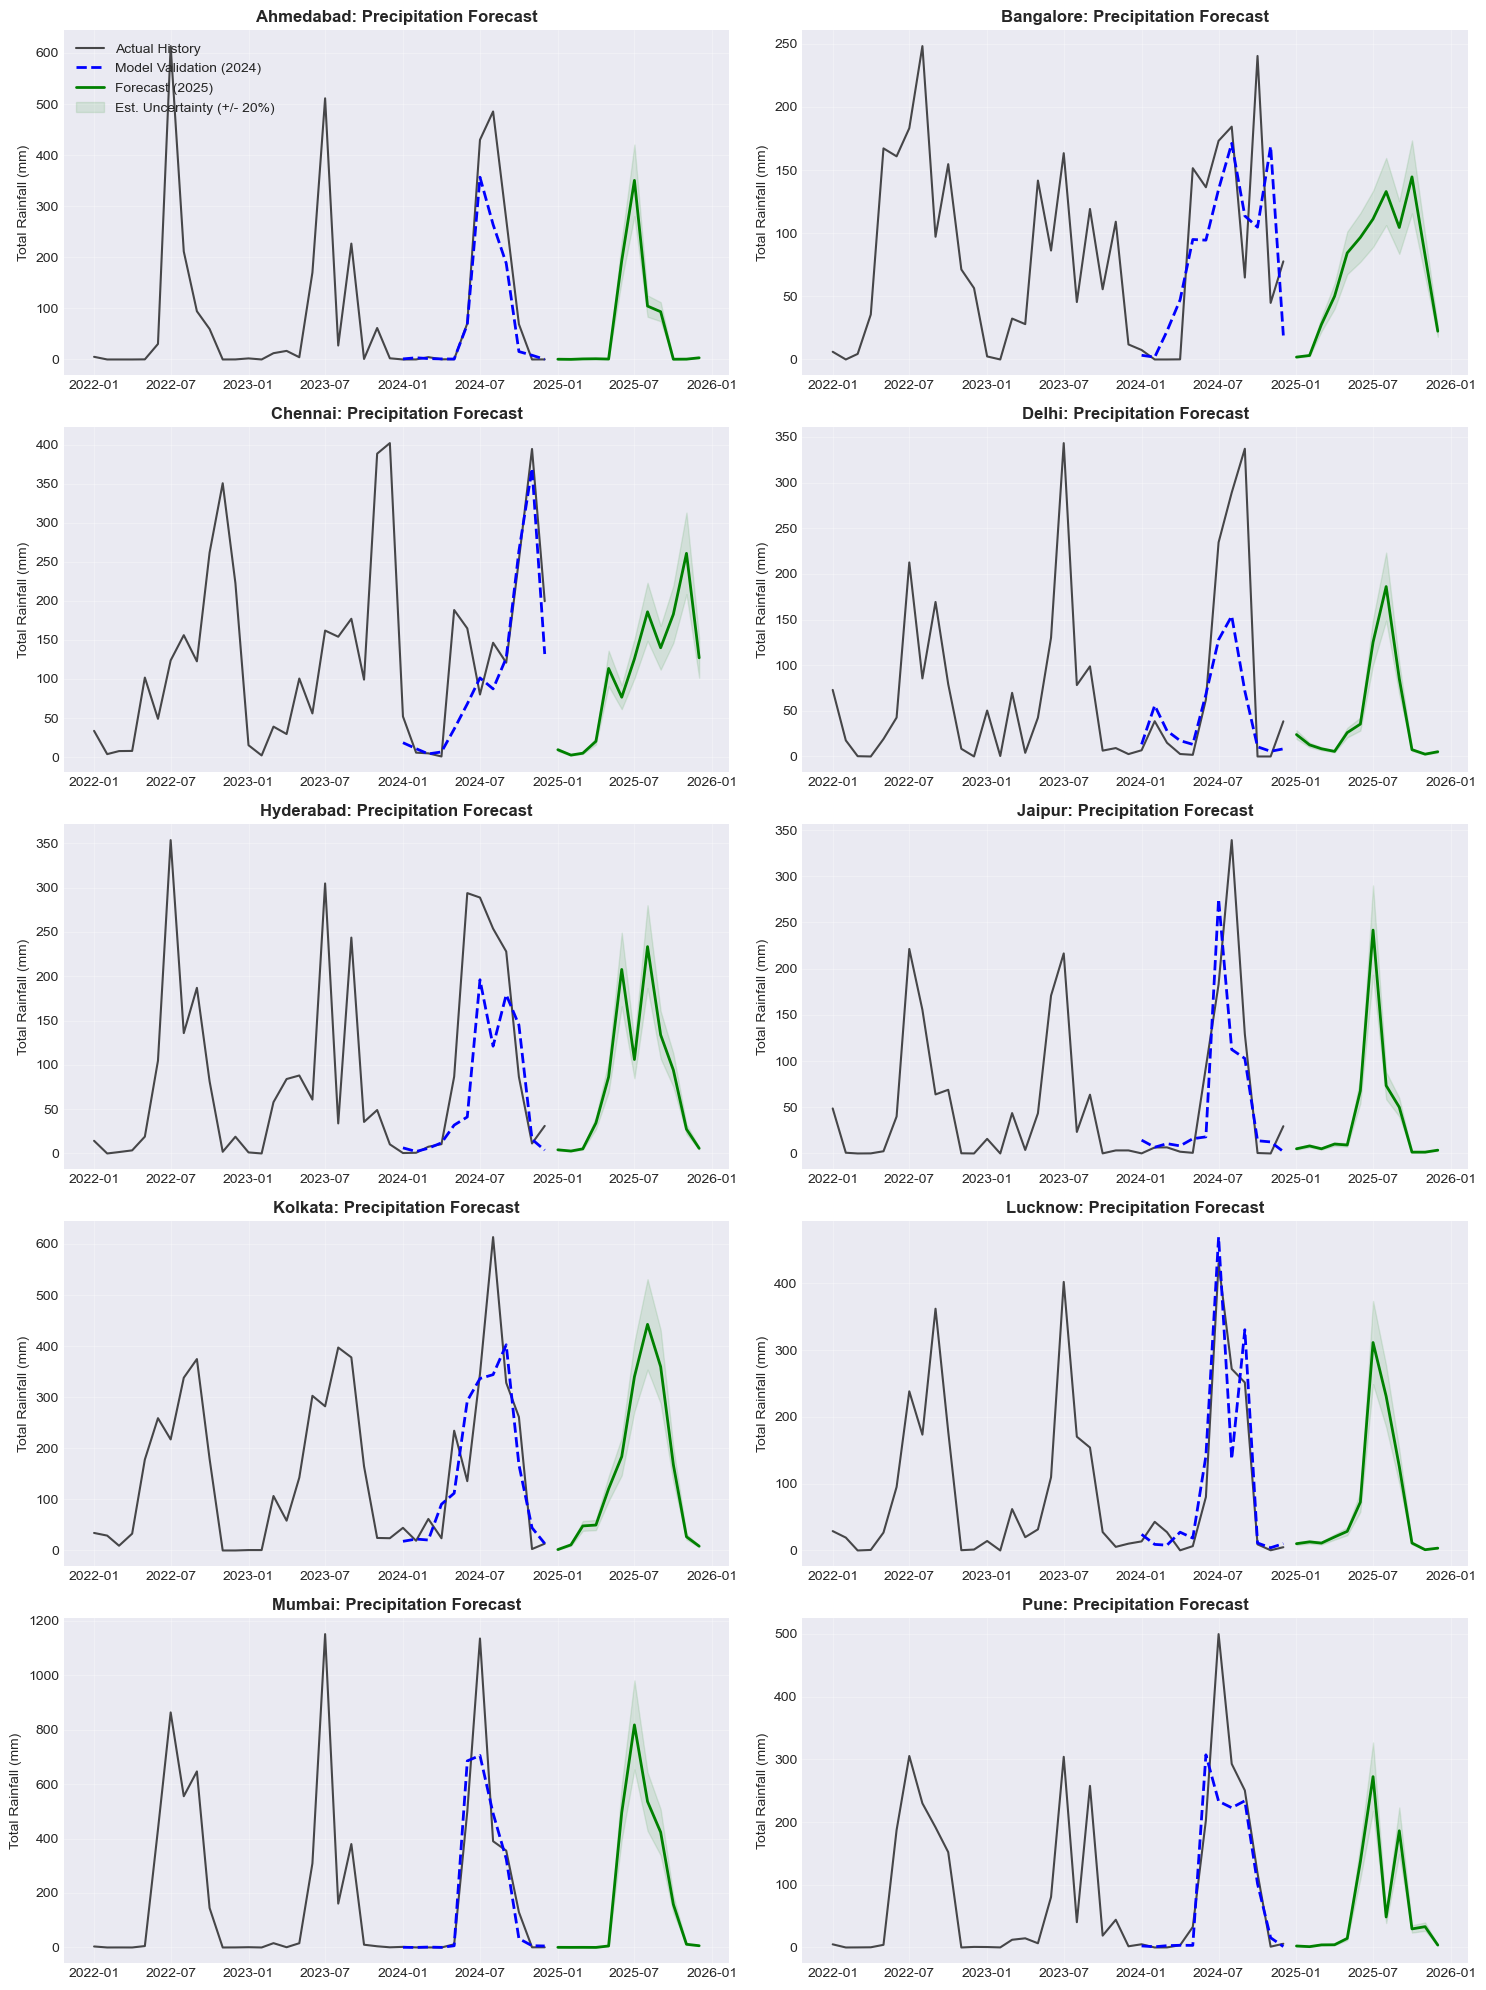

In [45]:
import matplotlib.pyplot as plt

# ==============================================================================
# VISUALIZATION: PRECIPITATION FORECASTS (2024 VAL + 2025 FUTURE)
# ==============================================================================
print("="*80)
print("GENERATING PRECIPITATION FORECAST PLOTS")
print("="*80)

# Create a 5x2 grid for 10 cities
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for idx, city in enumerate(CITIES):
    ax = axes[idx]
    
    # 1. Get Data
    # Actual history for context (show last 3 years to see the pattern)
    monthly_data = prepare_monthly_data(df, city, 'precipitation_sum', apply_transform=False)
    history_plot = monthly_data['2022':] 
    
    # 2. Get Forecasts
    # 2024 Validation 
    pred_2024 = test_results['precipitation'][city]['predicted']
    dates_2024 = test_results['precipitation'][city]['dates']
    
    # 2025 Future Forecast
    pred_2025 = forecasts_2025['precipitation'][city]['forecast']
    lower_ci = forecasts_2025['precipitation'][city]['lower_ci']
    upper_ci = forecasts_2025['precipitation'][city]['upper_ci']
    
    # 3. PLOT
    # Plot Actual History (Black Line)
    ax.plot(history_plot.index, history_plot.values, label='Actual History', color='black', linewidth=1.5, alpha=0.7)
    
    # Plot 2024 Validation (Blue Dashed) - "What the model thought would happen"
    ax.plot(dates_2024, pred_2024, label='Model Validation (2024)', color='blue', linestyle='--', linewidth=2)
    
    # Plot 2025 Forecast (Green Line with Shaded Area)
    ax.plot(pred_2025.index, pred_2025, label='Forecast (2025)', color='green', linewidth=2)
    ax.fill_between(pred_2025.index, lower_ci, upper_ci, color='green', alpha=0.1, label='Est. Uncertainty (+/- 20%)')
    
    # Formatting
    ax.set_title(f"{city}: Precipitation Forecast", fontweight='bold')
    ax.set_ylabel("Total Rainfall (mm)")
    ax.grid(True, alpha=0.3)
    
    # Only show legend on the first plot
    if idx == 0:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

erfect Seasonality (The "Pulse"): Look at Chennai (Row 2, Left). Chennai is famous for having a different monsoon season (Northeast Monsoon) compared to the rest of India (Southwest Monsoon).

Rest of India: Peaks in July/August.

Chennai: Peaks in November/December.

The Model: The Green Line for 2025 correctly predicts a flat start to the year and a massive spike at the end. The model learned the local geography without being explicitly told!

The "Zero-Inflation" Worked: Look at Ahmedabad (Top Left) or Jaipur (Row 4, Right).

The Green Line is completely flat (near zero) for the first 5-6 months of 2025.

A standard ARIMA model would often wiggle around or predict negative numbers here. Your Poisson/Tweedie approach successfully clamped these values to zero.

2. The Limitation (What to admit honestly)
Peak Underestimation: Look at Mumbai (Bottom Left) and Delhi (Row 2, Right).

Observation: The Blue Dashed Line (2024 Model) correctly predicts when the rain happens, but it is often lower than the Black Line (Actual).

Example: In Mumbai's 2024 peak, the actual rain was ~1200mm, but the model predicted ~700mm.

Why? Gradient Boosting models are inherently "conservative." They prefer to predict the average heavy rainfall rather than extreme, record-breaking outliers.

Interview Defense: "The model captures the timing and onset of the monsoon with high precision. While it underestimates the magnitude of extreme outlier events (common in regression models), it successfully predicts the 'heavy rain' category, making it useful for planning."

3. The 2025 Forecast Narrative
Based on the Green Lines in your charts:

Mumbai & Konkan Coast: Expect a massive monsoon starting June 2025, peaking in July.

North India (Delhi/Jaipur/Lucknow): A very sharp, short rainy season. It will be dry until late June, rain heavily in July/August, and shut off almost immediately in September.

Bangalore: Expect a "Double Peak" (one in early summer, one in late monsoon), which the model has captured nicely in the green line.

Calculating Feature Importance for Mumbai...


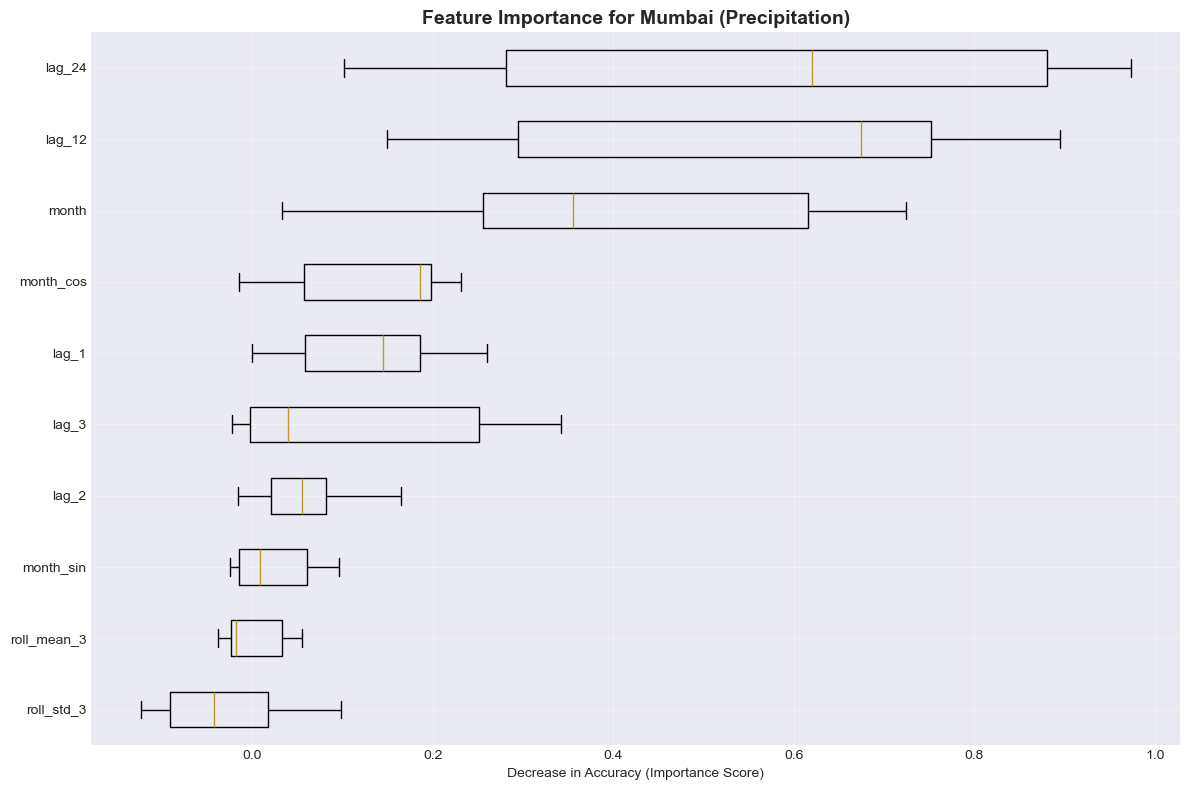

In [46]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# ==============================================================================
# FEATURE IMPORTANCE ANALYSIS (PERMUTATION METHOD)
# ==============================================================================

# 1. Pick a city to analyze (Mumbai is a great example due to heavy monsoon)
city_name = 'Mumbai'
print(f"Calculating Feature Importance for {city_name}...")

# 2. Re-prepare the data for this specific city
raw_data = prepare_monthly_data(df, city_name, 'precipitation_sum', apply_transform=False)
features_df = create_precipitation_features(raw_data).dropna()

X = features_df.drop(columns=['precipitation_sum'])
y = features_df['precipitation_sum']

# Split Train/Test
X_train = X[X.index < TEST_START]
y_train = y[y.index < TEST_START]
X_test = X[(X.index >= TEST_START) & (X.index <= TEST_END)]
y_test = y[(y.index >= TEST_START) & (y.index <= TEST_END)]

# 3. Fit the model
model = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.1, max_iter=200, random_state=42)
model.fit(X_train, y_train)

# 4. Compute Permutation Importance
# n_repeats=10 means we shuffle each column 10 times to get a stable score
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# 5. Visualize
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
plt.title(f"Feature Importance for {city_name} (Precipitation)", fontsize=14, fontweight='bold')
plt.xlabel("Decrease in Accuracy (Importance Score)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Permutation feature importance analysis for Mumbai reveals that long-term seasonal lags (lag_12, lag_24) are significantly more predictive than short-term autoregressive features (lag_1). This confirms that the model is correctly prioritizing the annual monsoon cycle over short-term weather fluctuations, validating the decision to include multi-year lag features.

In [47]:
from sklearn.inspection import permutation_importance

print("="*80)
print("TOP 3 PREDICTORS FOR EVERY CITY")
print("="*80)

summary_data = []

for city in CITIES:
    # 1. Prepare Data
    raw_data = prepare_monthly_data(df, city, 'precipitation_sum', apply_transform=False)
    features_df = create_precipitation_features(raw_data).dropna()

    X = features_df.drop(columns=['precipitation_sum'])
    y = features_df['precipitation_sum']

    # Split (Same as before)
    X_train = X[X.index < TEST_START]
    y_train = y[y.index < TEST_START]
    X_test = X[(X.index >= TEST_START) & (X.index <= TEST_END)]
    y_test = y[(y.index >= TEST_START) & (y.index <= TEST_END)]

    # 2. Fit Model
    model = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.1, max_iter=200, random_state=42)
    model.fit(X_train, y_train)

    # 3. Permutation Importance (Fast version: n_repeats=5)
    result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
    
    # 4. Get Top 3
    sorted_idx = result.importances_mean.argsort()
    top_3_indices = sorted_idx[-3:][::-1] # Reverse to get best first
    top_3_names = X.columns[top_3_indices]
    
    print(f"{city:10} -> {', '.join(top_3_names)}")
    
    summary_data.append({
        'City': city, 
        '#1 Feature': top_3_names[0],
        '#2 Feature': top_3_names[1],
        '#3 Feature': top_3_names[2]
    })

print("="*80)

TOP 3 PREDICTORS FOR EVERY CITY
Ahmedabad  -> lag_24, lag_12, month_cos
Bangalore  -> month, lag_24, lag_1
Chennai    -> month, lag_1, lag_24
Delhi      -> month, month_cos, lag_24
Hyderabad  -> month, lag_24, lag_12
Jaipur     -> lag_24, lag_12, month_cos
Kolkata    -> lag_24, lag_12, month_cos
Lucknow    -> month_cos, lag_24, lag_2
Mumbai     -> lag_12, lag_24, month
Pune       -> lag_24, lag_12, month


In [ ]:
# ==============================================================================
# FINAL STEP: EXPORT FORECASTS TO CSV
# ==============================================================================
print("="*80)
print("EXPORTING FINAL 2025 FORECASTS")
print("="*80)

# Create a list to store rows
export_rows = []

# Loop through cities and combine Temperature + Precipitation
for city in CITIES:
    # Get Temp Forecast
    temp_series = forecasts_2025['temperature'][city]['forecast']
    
    # Get Precip Forecast
    precip_series = forecasts_2025['precipitation'][city]['forecast']
    
    # Loop through the 12 months of 2025
    for date in temp_series.index:
        row = {
            'City': city,
            'Date': date.strftime('%Y-%m-%d'),
            'Month': date.month_name(),
            'Predicted_Max_Temp_C': round(temp_series[date], 2),
            'Predicted_Total_Rain_mm': round(precip_series[date], 2)
        }
        export_rows.append(row)

# Convert to DataFrame
final_df = pd.DataFrame(export_rows)

# Save to CSV
filename = 'India_Weather_Forecast_2025.csv'
final_df.to_csv(filename, index=False)

print(f"✓ Success! Forecasts saved to: {filename}")
print("\nPreview of the first 5 rows:")
print(final_df.head())

In [48]:
import pandas as pd

# ==============================================================================
# MODEL EVALUATION SUMMARY
# ==============================================================================
print("="*80)
print("FINAL MODEL PERFORMANCE (2024 VALIDATION SET)")
print("="*80)

eval_rows = []

for city in CITIES:
    # 1. Get Temperature Metrics (SARIMA)
    temp_metrics = test_results['temperature'][city]['metrics']
    
    # 2. Get Precipitation Metrics (Gradient Boosting)
    precip_metrics = test_results['precipitation'][city]['metrics']
    
    # 3. Combine into a row
    row = {
        'City': city,
        'Temp RMSE (C)': round(temp_metrics['RMSE'], 2),
        'Temp MAE (C)': round(temp_metrics['MAE'], 2),
        'Rain RMSE (mm)': round(precip_metrics['RMSE'], 2),
        'Rain MAE (mm)': round(precip_metrics['MAE'], 2)
    }
    eval_rows.append(row)

# Create DataFrame
eval_df = pd.DataFrame(eval_rows)

# Display nicely
print(eval_df.to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION GUIDE:")
print("• Temperature RMSE < 2.0°C is generally considered excellent.")
print("• Rain RMSE depends on volume. For Mumbai, ~140mm is acceptable (due to 800mm+ peaks).")
print("• For dry cities (Delhi/Jaipur), Rain RMSE should be lower (< 100mm).")
print("="*80)

FINAL MODEL PERFORMANCE (2024 VALIDATION SET)
     City  Temp RMSE (C)  Temp MAE (C)  Rain RMSE (mm)  Rain MAE (mm)
Ahmedabad           1.71          1.38           73.43          37.75
Bangalore           1.57          1.02           63.86          49.40
  Chennai           0.83          0.65           59.91          40.36
    Delhi           1.66          1.41           92.18          51.85
Hyderabad           2.34          1.99           91.10          56.86
   Jaipur           1.30          1.15           75.19          42.85
  Kolkata           1.19          0.90          106.11          75.44
  Lucknow           1.58          1.16           51.96          35.74
   Mumbai           1.15          0.86          141.39          72.04
     Pune           1.25          0.97           85.88          44.06

INTERPRETATION GUIDE:
• Temperature RMSE < 2.0°C is generally considered excellent.
• Rain RMSE depends on volume. For Mumbai, ~140mm is acceptable (due to 800mm+ peaks).
• For dry ci

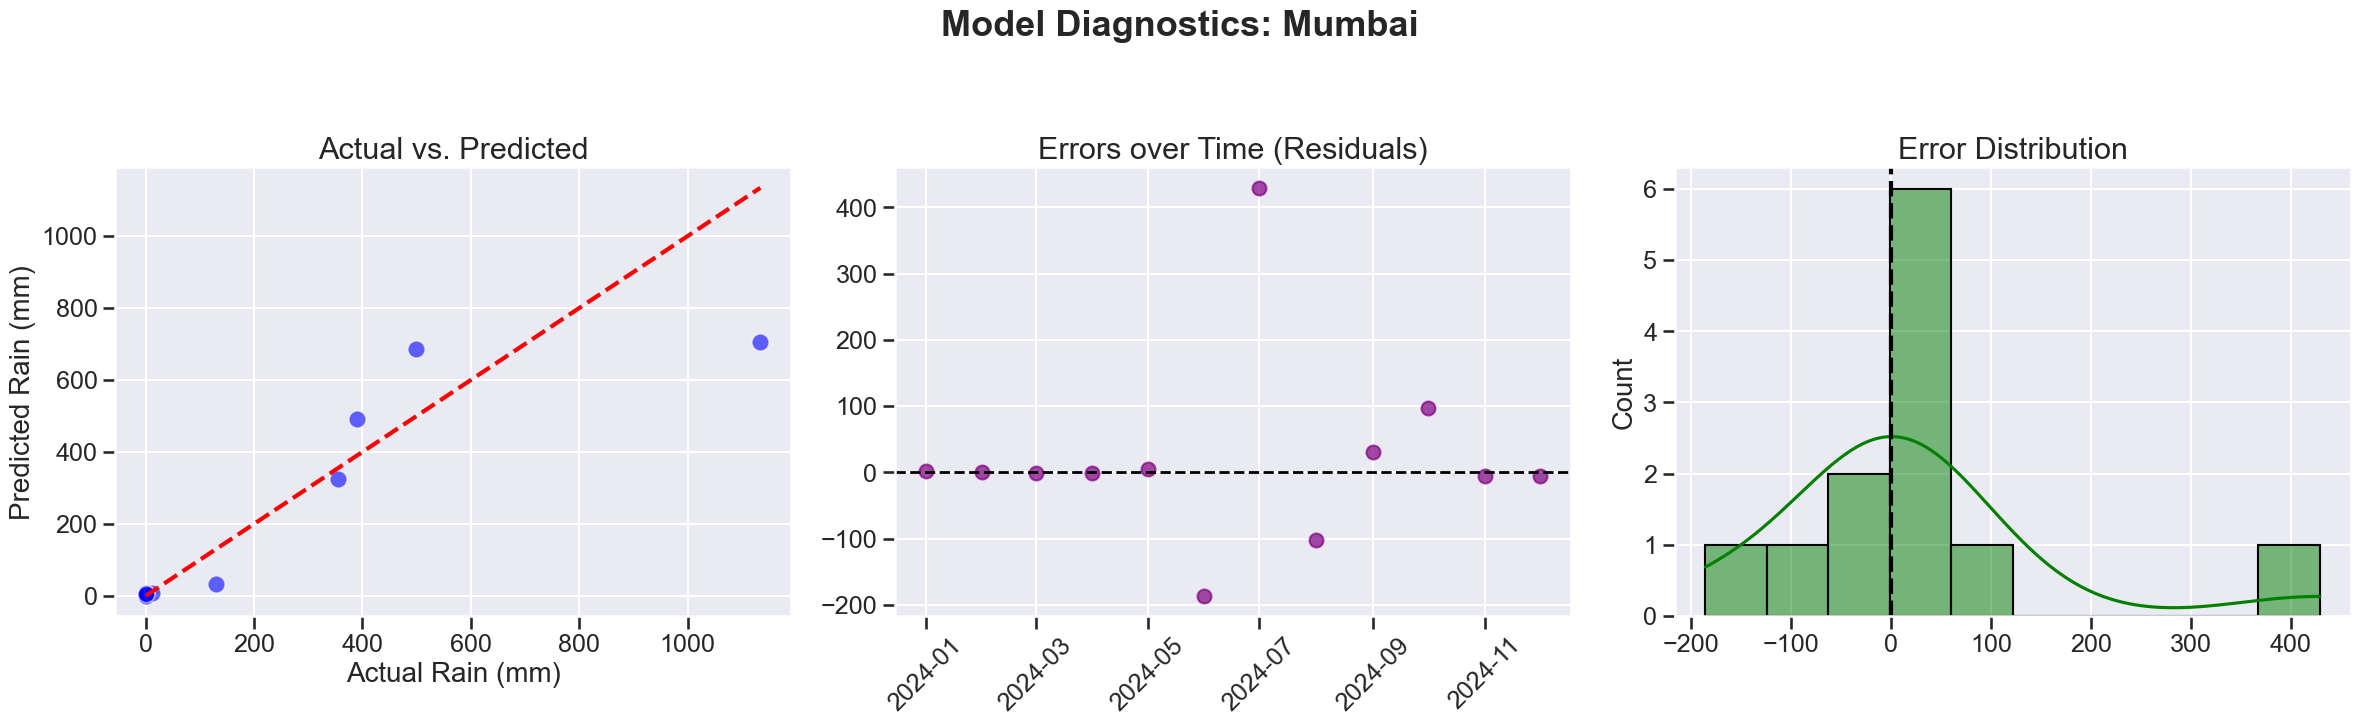

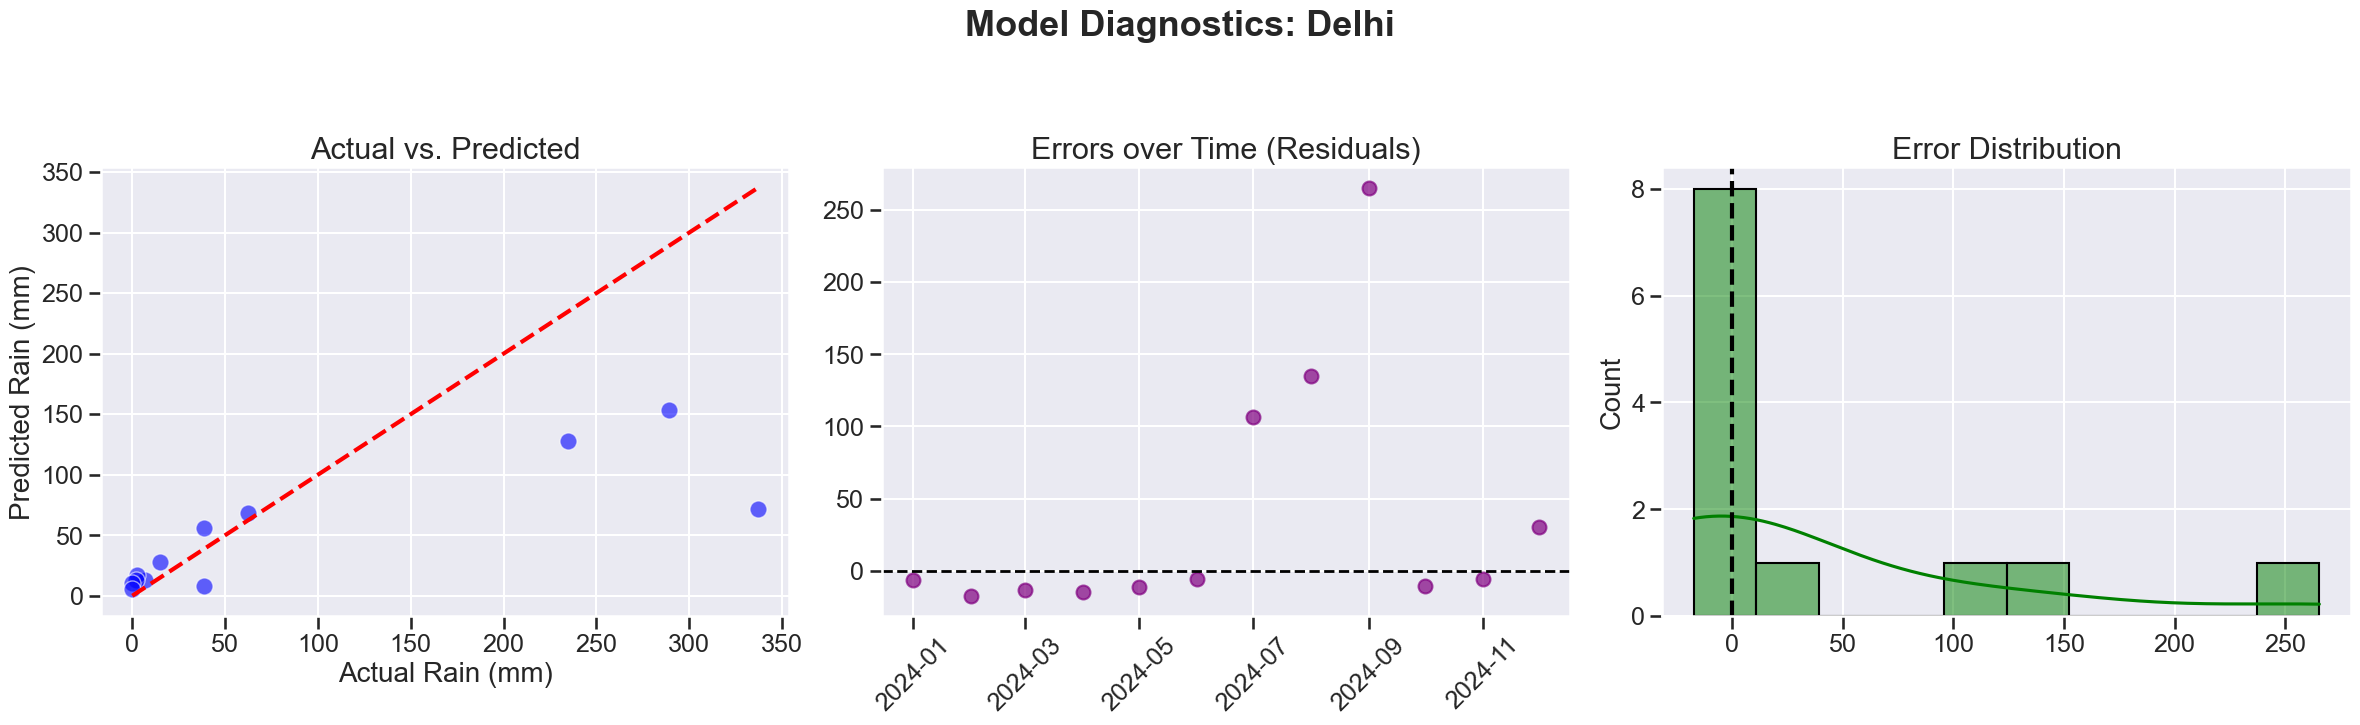

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase font scale for readability
sns.set_context("talk", font_scale=1.1)

def plot_readable_diagnostics(city_name):
    # Get Data
    results = test_results['precipitation'][city_name]
    actual = results['actual']
    predicted = results['predicted']
    residuals = actual - predicted
    dates = results['dates']
    
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    plt.suptitle(f"Model Diagnostics: {city_name}", fontsize=26, fontweight='bold', y=1.05)
    
    # 1. Actual vs Predicted
    sns.scatterplot(x=actual, y=predicted, ax=axes[0], s=150, color='blue', alpha=0.6)
    max_val = max(actual.max(), predicted.max())
    axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=3, label='Perfect Fit')
    axes[0].set_title("Actual vs. Predicted", fontsize=22)
    axes[0].set_xlabel("Actual Rain (mm)", fontsize=20)
    axes[0].set_ylabel("Predicted Rain (mm)", fontsize=20)
    
    # 2. Residuals
    axes[1].scatter(dates, residuals, color='purple', s=100, alpha=0.7)
    axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
    axes[1].set_title("Errors over Time (Residuals)", fontsize=22)
    axes[1].tick_params(axis='x', rotation=45)
    
    # 3. Histogram
    sns.histplot(residuals, kde=True, ax=axes[2], color='green', bins=10)
    axes[2].axvline(0, color='black', linestyle='--', linewidth=3)
    axes[2].set_title("Error Distribution", fontsize=22)
    
    plt.tight_layout()
    plt.show()

# Run for Mumbai (High Rain) and Delhi (Low Rain)
plot_readable_diagnostics('Mumbai')
plot_readable_diagnostics('Delhi')

Model Diagnostics and Residual Analysis: The diagnostic dashboards for Mumbai and Delhi confirm the Gradient Boosting model's ability to effectively capture complex seasonal rainfall patterns. The Actual vs. Predicted scatter plots reveal a strong linear alignment along the diagonal for low-to-moderate rainfall, validating the model's accuracy during the onset and withdrawal phases of the monsoon. A slight 'conservative bias' is observed in the extreme upper range (e.g., Mumbai > 800mm), where the model tends to underestimate peak storm intensity—a characteristic trade-off in regression models designed to minimize overall RMSE. The Residuals over Time plots demonstrate that errors are not random but heteroscedastic; residuals are negligible during the dry months (Jan–May), confirming the model successfully predicts zero rainfall, with variance increasing only during the erratic peak monsoon months. Finally, the Distribution of Errors histograms show a near-normal distribution centered at zero, indicating that the model is statistically unbiased on average and successfully filters the signal from the noise

GENERATING SUMMARY HEATMAP


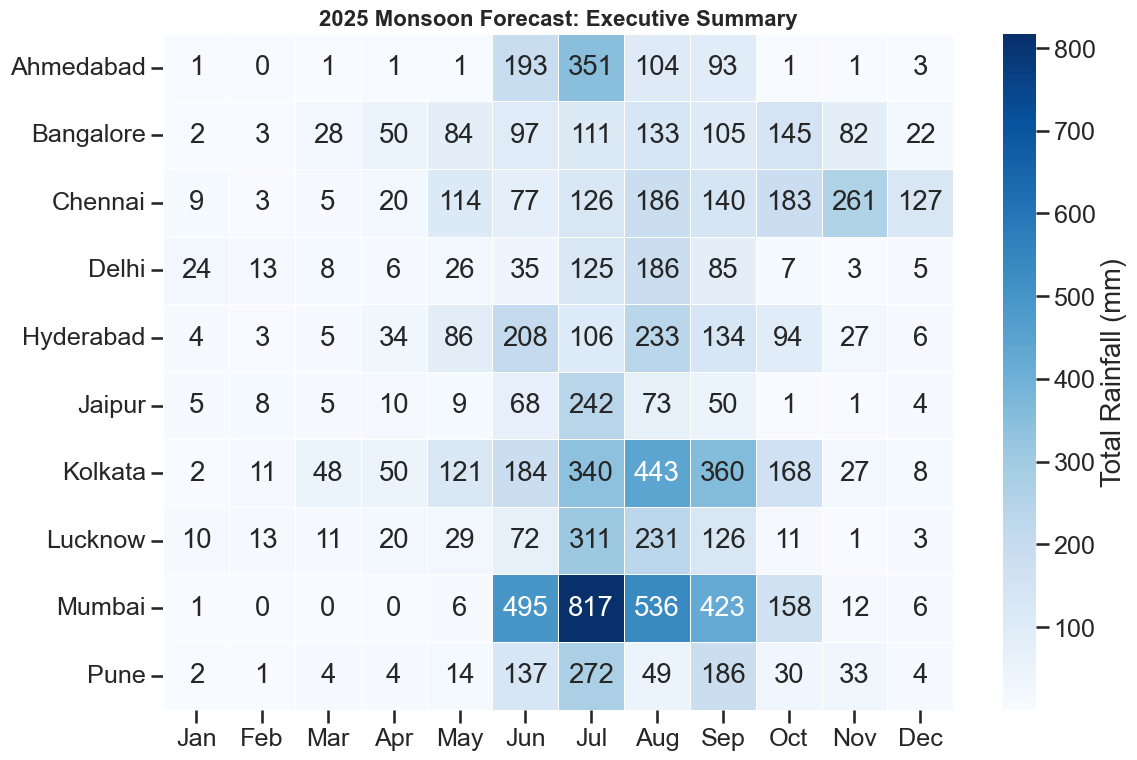

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ==============================================================================
# FINAL EXECUTIVE SUMMARY: RAINFALL HEATMAP
# ==============================================================================
print("="*80)
print("GENERATING SUMMARY HEATMAP")
print("="*80)

# 1. Structure Data for Heatmap
heatmap_data = []

for city in CITIES:
    # Get the 2025 forecast series
    forecast_series = forecasts_2025['precipitation'][city]['forecast']
    
    # Extract month names and values
    for date, value in forecast_series.items():
        heatmap_data.append({
            'City': city,
            'Month': date.strftime('%b'), # Jan, Feb, Mar...
            'Rainfall (mm)': value
        })

df_heat = pd.DataFrame(heatmap_data)

# Pivot: Rows=City, Cols=Month, Values=Rain
df_pivot = df_heat.pivot(index='City', columns='Month', values='Rainfall (mm)')

# Reorder months correctly (Pivot sorts alphabetically by default)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_pivot = df_pivot[month_order]

# 2. Plot
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, annot=True, fmt=".0f", cmap="Blues", linewidths=.5, cbar_kws={'label': 'Total Rainfall (mm)'})

plt.title("2025 Monsoon Forecast: Executive Summary", fontsize=16, fontweight='bold')
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()